<a href="https://colab.research.google.com/github/khizerismail89/MayStreamlit/blob/main/OLA_EnsembleLearning_KI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

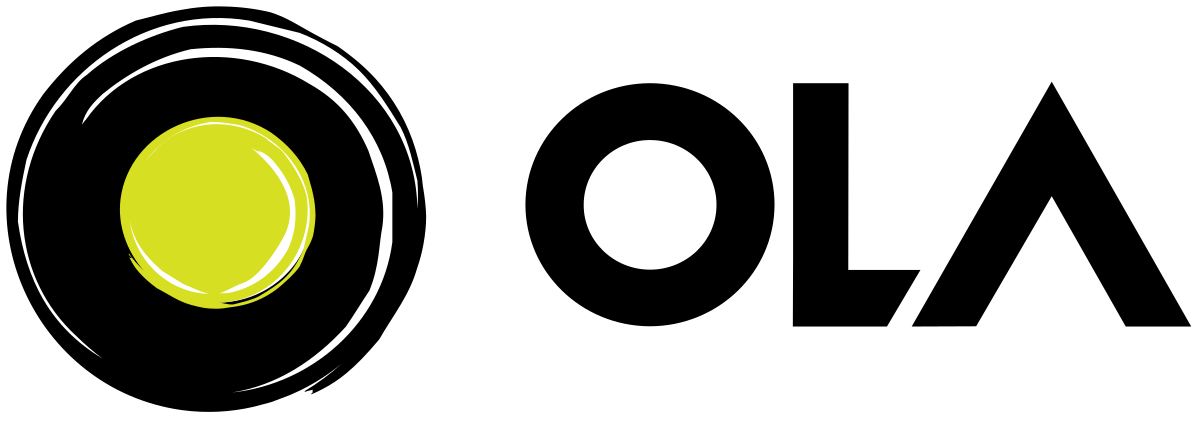

**Problem Statement from the ola Platform**

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

Demographics (city, age, gender etc.)
Tenure information (joining date, Last Date)
Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

In [206]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier # bagging ensemble algorithm
from sklearn.ensemble import GradientBoostingClassifier # boosting ensemble algorithm
import xgboost as xgb
from xgboost import XGBClassifier #Extreme Gradient boosting algorithm library

In [207]:
sns.set(context="notebook", style="whitegrid", palette="deep")

In [208]:
## loading the dataframe and storing into a variable
df = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv')

In [209]:
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [210]:
df.tail()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
19099,19099,08/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,740280,3
19100,19100,09/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,448370,3
19101,19101,10/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,0,2
19102,19102,11/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,200420,2
19103,19103,12/01/20,2788,30.0,0.0,C27,2,70254,06/08/20,NaN,2,2,411480,2


In [211]:
 # shape of the provided dataframe
print(f"The data frame has {df.shape[0]} number of rows and {df.shape[1]} number of columns.")

The data frame has 19104 number of rows and 14 number of columns.


In [212]:
# dropping the column 'Unnamed:0' as its not giving any benefit and also renaming the column 'MM-YY' as 'Reporting Date'
df = df.drop('Unnamed: 0',axis=1)
df.rename(columns={'MMM-YY':'Reporting_Date'}, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Reporting_Date        19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


We can infere from the above information that there are records of 1616 out of 19104 with last working date or drivers who have Churned.

There are some missing values in driver's age and driver's gender column.

We need to convert three columns (Reporting date, Joining date and Last working date) to date time format.

 Rest all is fine. We will further do analysis to get more details.

In [213]:
df.describe()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19043.000000,19052.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,1415.591133,34.668435,0.418749,1.021671,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,810.705321,6.257912,0.493367,0.800167,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,1.000000,21.000000,0.000000,0.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,710.000000,30.000000,0.000000,0.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,1417.000000,34.000000,0.000000,1.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,2137.000000,39.000000,1.000000,2.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,2788.000000,58.000000,1.000000,2.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


Inference:

* Ola has hired taxi drivers only from age 21 till 58 which is a very good ethic.

* There are drivers with mix of education level from 10+ till graduates.

* Income variation is also huge from 10k till 1.8 lacs. Where the mean and median are not so much varying means we can say the curve is almost a normal curve. We can further check it with visuals.

# Data Cleaning steps and Imputation

In [214]:
#Converting necessary columns to date time format for easy analysis and calculations

df['Reporting_Date'] = pd.to_datetime(df['Reporting_Date'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])

df.dtypes

Reporting_Date          datetime64[ns]
Driver_ID                        int64
Age                            float64
Gender                         float64
City                            object
Education_Level                  int64
Income                           int64
Dateofjoining           datetime64[ns]
LastWorkingDate         datetime64[ns]
Joining Designation              int64
Grade                            int64
Total Business Value             int64
Quarterly Rating                 int64
dtype: object

In [215]:
# To find the unique drivers present in the data frame
print(f"There are {df['Driver_ID'].nunique()} unique drivers in the provided dataframe")

There are 2381 unique drivers in the provided dataframe


In [216]:
# Finding out if driver's age missing values in column and combaining with matched driver_id's age
df[df['Age'].isnull()]

,Reporting_Date,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
72,2020-02-01,20,NaN,1.0,C19,0,40342,2019-10-25,NaT,3,3,0,1
97,2019-10-01,22,NaN,0.0,C10,2,31224,2018-05-25,NaT,1,1,200000,3
110,2019-07-01,24,NaN,0.0,C24,2,76308,2018-05-25,NaT,1,2,203240,3
212,2019-11-01,40,NaN,0.0,C15,0,59182,2019-11-08,NaT,2,2,0,1
261,2019-05-01,49,NaN,0.0,C20,0,53039,2018-05-25,NaT,1,2,124190,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18395,2020-05-01,2690,NaN,0.0,C11,2,77662,2018-07-17,NaT,1,2,692600,4
18722,2020-08-01,2730,NaN,1.0,C16,2,69924,2019-07-08,NaT,2,2,161860,2
18780,2019-03-01,2738,NaN,0.0,C17,0,23068,2018-09-08,NaT,1,1,639780,3
18843,2019-01-01,2751,NaN,0.0,C17,2,53115,2015-11-05,NaT,1,1,506550,3


After high level analysis it is understood that the driver's age missed values maybe a data entry issue and not NaN value really. So we can replace the age with the same value from other row of matching driver_id.

In [217]:
print("The number of drivers with missing 'Age' before processing are : ", df[df['Age'].isnull()]['Driver_ID'].nunique())

The number of drivers with missing 'Age' before processing are :  57


In [218]:
#Copying the df into a new dataframe

X = df.copy()

# Finding the missing values of Age and imputing it with the most frequent Age found with that driver ID and filling up

for i in df[df['Age'].isnull()]['Driver_ID']:
  age = df[df['Driver_ID'] == i]
  # Use .loc to filter the DataFrame and fill missing values for the specific Driver_ID
  X.loc[X['Driver_ID'] == i, 'Age'] = age['Age'].mode()[0]

In [219]:
print("The number of drivers with missing 'Age' After processing are : ", X[X['Age'].isna()]['Driver_ID'].nunique())

The number of drivers with missing 'Age' After processing are :  0


In [220]:
print("Number of missing values in 'gender' column before processing: ", df[df['Gender'].isnull()]['Driver_ID'].nunique())

Number of missing values in 'gender' column before processing:  51


In [221]:
# Finding out if driver's gender missing values

df[df['Gender'].isnull()]

,Reporting_Date,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
240,2019-02-01,43,27.0,NaN,C15,0,12906,2018-07-13,2019-02-20,1,1,0,1
258,2019-02-01,49,21.0,NaN,C20,0,53039,2018-05-25,NaT,1,2,0,1
264,2019-08-01,49,21.0,NaN,C20,0,53039,2018-05-25,NaT,1,2,300300,2
466,2019-08-01,68,31.0,NaN,C29,0,79288,2015-10-18,NaT,1,3,544930,3
820,2019-02-01,116,21.0,NaN,C11,0,16477,2018-12-04,NaT,1,1,129590,1
859,2019-11-01,119,31.0,NaN,C29,1,71000,2019-11-16,NaT,3,3,0,1
1514,2020-12-01,225,32.0,NaN,C14,0,44792,2020-07-13,NaT,3,3,337020,3
1892,2019-08-01,296,31.0,NaN,C20,1,65094,2018-06-10,NaT,1,2,145670,2
2277,2019-02-01,354,31.0,NaN,C11,0,60555,2018-11-30,NaT,1,1,0,1
2359,2020-03-01,365,24.0,NaN,C22,0,44740,2020-02-01,NaT,2,2,0,1


In [222]:
# FInding the missing values of gender and imputing it with the most frequent gender found with that driver ID and filling up
for i in df[df['Gender'].isnull()]['Driver_ID']:
  gender = df[df['Driver_ID'] == i]
  # Use .loc to filter the DataFrame and fill missing values for the specific Driver_ID
  X.loc[X['Driver_ID'] == i, 'Gender'] = gender['Gender'].mode()[0]

In [223]:
print("Number of actual missing values in 'gender' column after processing: ", X[X['Gender'].isnull()]['Driver_ID'].nunique())

Number of actual missing values in 'gender' column after processing:  0


In [224]:
X.isna().sum()

Reporting_Date              0
Driver_ID                   0
Age                         0
Gender                      0
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

We can observe that all the missing values in Age and Gender has been filled up with the most frequent Age and Gender for that driver's ID.

We now have missing values only for the feature 'LastWorkingDay' which we will keep it as it is to find the Target Feature.

In future if we get any data with all the values of Age and Gender missing for a particular driver then that value is replaced with the most frequest value from the entire lot. So, I will be writing a piece of code for that particular scenario.

In [225]:
# Writing a code to handle a situation where data has missing values of Age for all the rows of same driver and missing values of gender for all the rows of the same driver

################

# for Gender

for i in df[df['Gender'].isnull()]['Driver_ID']:
  gender = df[df['Driver_ID'] == i]
  X.loc[X['Driver_ID'] == i, 'Gender'] = X['Gender'].mode()[0]

####################
# for Age

for i in df[df['Age'].isnull()]['Driver_ID']:
  age = df[df['Driver_ID'] == i]
  X.loc[X['Driver_ID'] == i, 'Age'] = X['Age'].mode()[0]


# Feature Engineering

Creating new Features for Income difference flag if its increasing month on month then we flag it with '1' else we will flag it with '0'.

Similarly creating new feature for Rating difference and flagging it with '1' if the quarterly rating has increased and '0' if its quarterly rating has decreased or as it is.

Creating 'Target' feature (Churn flag) with flag as '1' if the driver has left the platform and if the driver has not left the platform then flag it with '0'.

In [226]:
# creating a new feature as 'Income_diff' to check if there is any increase in the income and marking them with 1 or 0.
X.sort_values(by = ['Driver_ID', 'Reporting_Date'], inplace = True)
X['Income_flag'] = X.groupby('Driver_ID')['Income'].diff(periods = 1) > 0
X['Income_flag'] = X['Income_flag'].replace({True: 1, False: 0})
X.Income_flag.value_counts()

Income_flag
0    19060
1       44
Name: count, dtype: int64

In [227]:
# creating a new feature as 'rating_diff' to check if there is any increase in the income and marking them with 1 or 0.

X['Rating_flag'] = X.groupby('Driver_ID')['Quarterly Rating'].diff(periods = 1) > 0
X['Rating_flag'] = X['Rating_flag'].replace({True: 1, False: 0})
X['Rating_flag'].value_counts()

Rating_flag
0    17859
1     1245
Name: count, dtype: int64

In [239]:
'''This entire cell is created to create a new dataframe and then create a new feature which gives a flag to a driver if it has ever made any refund/got cancelled ride
    or have to pay an EMI and for which the total business generated value for that month goes negative.
    We are finidng this out to find the co-relation between churn rate and negative business impacts.
'''

ola = X.copy()
ola['EMI_Refund_Cancel_Drives'] = X['Total Business Value'].apply(lambda x: 1 if x < 0 else 0)
# group the driver IDs to find if the driver has a single 1 in the column 'EMI_Refund_Cancel_Drives' then return  1 else 0
ola['Neg_Bus'] = ola.groupby('Driver_ID')['EMI_Refund_Cancel_Drives'].transform(lambda x: 1 if (x == 1).sum() == 1 else 0)

,Reporting_Date,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Income_flag,Rating_flag,No_of_Months_reported,Total_Revenue_acquired,Churn_flag,EMI_Refund_Cancel_Drives,Neg_Bus
0,2019-01-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,2381060,2,0,0,3,1715580,1,0,1
1,2019-02-01,1,28.0,0.0,C23,2,57387,2018-12-24,NaT,1,1,-665480,2,0,0,3,1715580,1,1,1
2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2,0,0,3,1715580,1,0,1
3,2020-11-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1,0,0,2,0,0,0,0
4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1,0,0,2,0,0,0,0


In [229]:
# finding the number of months each driver reported on the platform
X['No_of_Months_reported'] = X.groupby('Driver_ID')['Reporting_Date'].transform('count')

In [230]:
## finding out the total revenue or business generated to the platform by the driver in the reported months:

X['Total_Revenue_acquired'] = X.groupby('Driver_ID')['Total Business Value'].transform('sum')

In [231]:
#Creating a new Target feature to show the churn flag with '1' if the driver has left the platform else '0'.

X['Churn_flag'] = X.groupby('Driver_ID')['LastWorkingDate'].transform(lambda x: 1 if x.any() else 0)

We will be creating a new dataframe now by grouping with the driver ID and picking only the last row of each driver's . As the dataframe X is already sorted with values Driver ID and reporting month. Means we will have the lastworkigndate only in the last row of each driver.

In [232]:
# grouping the dataframe with driver ID and picking the last row of each driver ID to have all the necessary details for further analysis:
ola_df = X.groupby('Driver_ID').tail(1).reset_index()
ola_df.head()

,index,Reporting_Date,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Income_flag,Rating_flag,No_of_Months_reported,Total_Revenue_acquired,Churn_flag
0,2,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,2,0,0,3,1715580,1
1,4,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,1,0,0,2,0,0
2,9,2020-04-01,4,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,0,1,0,0,5,350000,1
3,12,2019-03-01,5,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07,1,1,0,1,0,0,3,120360,1
4,17,2020-12-01,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,3,3,0,2,0,0,5,1265000,0


**Dropping the columns:-**

 ❎'Total Business Value': as we have already taken aggregate of it and since we have just grouped the main dataframe this feature will not give any meaning for further analysis.

 ❎ 'index': since it was created automatically after the reset_index() functionw as run on the above dataframe and it is a junk feature now.

 ❎ 'Quarterly Rating': Since we haev already gropped the dataframe and taken out the quarterly difference flag. This feature gives no importance now.**bold text**

In [233]:
## removing unnecessary columns

cols_to_remove = ['index', 'Total Business Value', 'Quarterly Rating']
ola_df.drop(cols_to_remove, axis=1, inplace=True)

In [234]:
#sample final dataframe view
ola_df.head()

,Reporting_Date,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Income_flag,Rating_flag,No_of_Months_reported,Total_Revenue_acquired,Churn_flag
0,2019-03-01,1,28.0,0.0,C23,2,57387,2018-12-24,2019-03-11,1,1,0,0,3,1715580,1
1,2020-12-01,2,31.0,0.0,C7,2,67016,2020-11-06,NaT,2,2,0,0,2,0,0
2,2020-04-01,4,43.0,0.0,C13,2,65603,2019-12-07,2020-04-27,2,2,0,0,5,350000,1
3,2019-03-01,5,29.0,0.0,C9,0,46368,2019-01-09,2019-03-07,1,1,0,0,3,120360,1
4,2020-12-01,6,31.0,1.0,C11,1,78728,2020-07-31,NaT,3,3,0,0,5,1265000,0


▶ We will further use the above dataframe 'ola_df' for all our univariate and bivariate distribution and visual analysis.

# Univariate and Bivariate Analysis

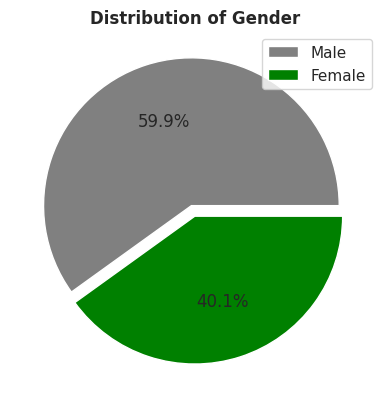

In [235]:
# Gender wise driver distribution
gender = ola_df['Gender'].map({0: 'Male', 1: 'Female'}).value_counts()
plt.pie(gender, autopct='%1.1f%%', colors =["grey", "green"], explode = [.075,0])
plt.title('Distribution of Gender', fontweight = 'bold')
plt.legend(gender.index)
plt.show()

We can observe that there are about 60% of male drivers and 40% of female drivers.

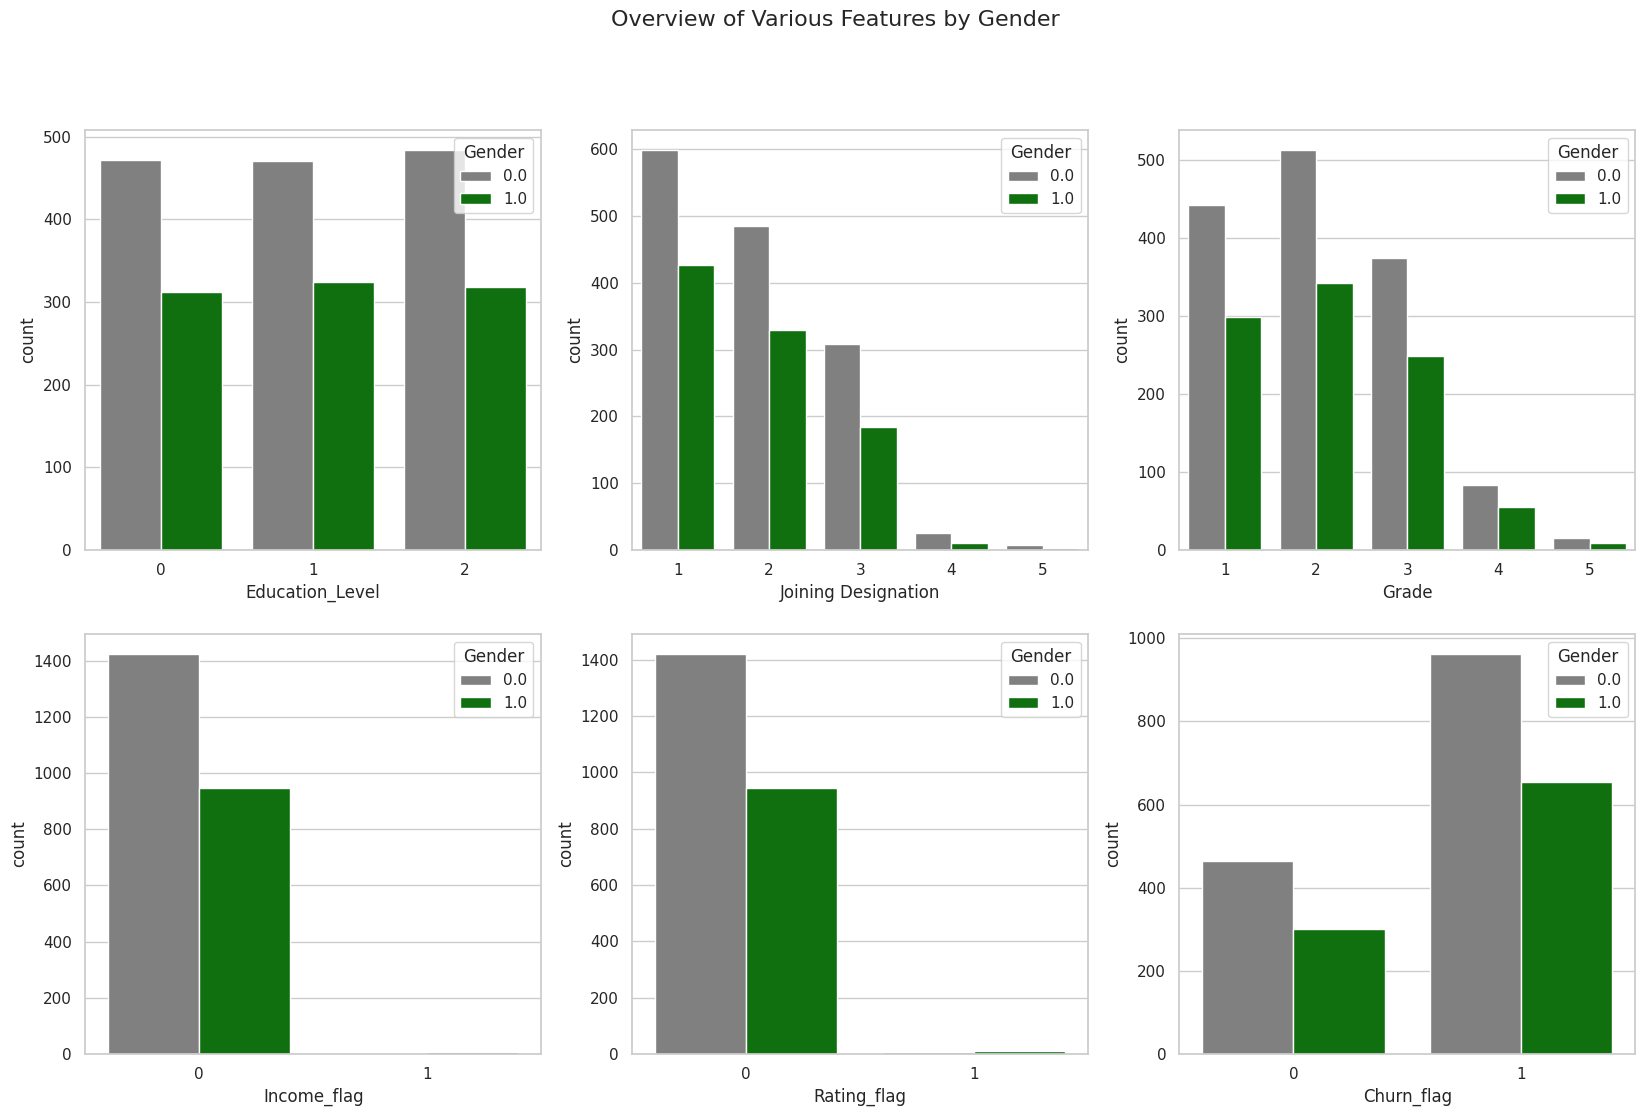

In [236]:
## Generating a Bi-Variate analysis to show the impacting features with respect to Gender


fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Overview of Various Features by Gender", fontsize=16)

sns.countplot(ax=axes[0, 0], data=ola_df, x="Education_Level", hue="Gender" , palette=["grey", "green"])
sns.countplot(ax=axes[0, 1], data=ola_df, x="Joining Designation", hue="Gender", palette=["grey", "green"])
sns.countplot(ax=axes[0, 2], data=ola_df, x="Grade", hue="Gender", palette=["grey", "green"])
sns.countplot(ax=axes[1, 0], data=ola_df, x="Income_flag", hue="Gender", palette=["grey", "green"])
sns.countplot(ax=axes[1, 1], data=ola_df, x="Rating_flag", hue="Gender", palette=["grey", "green"])
sns.countplot(ax=axes[1, 2], data=ola_df, x="Churn_flag", hue="Gender", palette=["grey", "green"])

plt.show()

We can infere from the above plot that in all the feature analysis 'Male' gender is leading.

▶ The Education level for all three class is almost same for all the drivers with Males leading the front among females.

▶ The joining designation of the drivers is in decreasing order from 1 to 5. With males being dominated in all the designations compared to females.

▶ Most number of drivers with grade 2 followed by grade 1 and grade 3 have been reported at the time of joining again with Males being dominating among females.

▶ We can infere that the Income flag for the drivers whose income is decreasing are more compared to income flag where income is increasing. Again with Males dominating the featured data.

▶ We can also infere that the Quarterly rating flag with decreasing rating has been flagged more compared to increasing flag. We can also observe that the Males are more in decreasing rating compared to Female and with increasing rating we see Females dominating over Males.

▶ The churn and Non-churn rate is also higher in the Male drivers comapred to Female drivers.



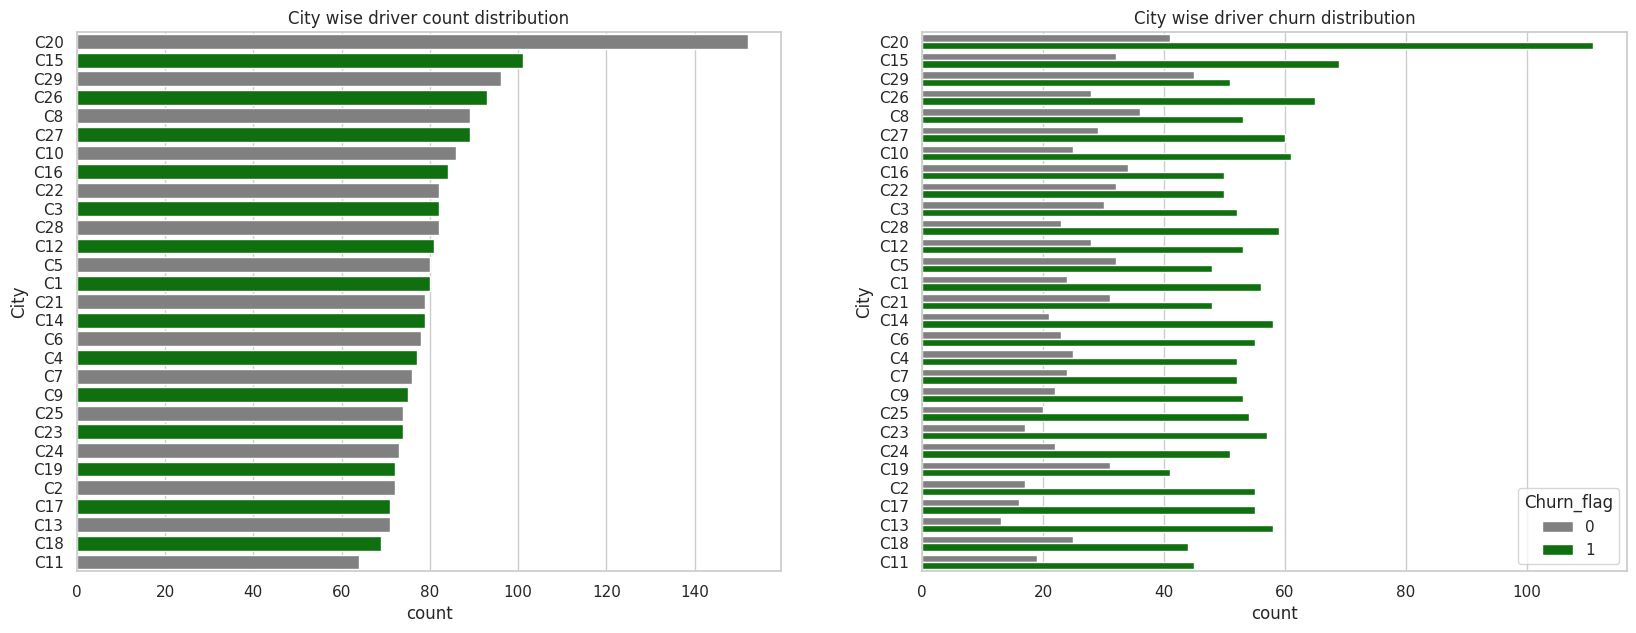

In [237]:
## plotting city wise driver distribution and churn rate distirubution city wise
plt.figure(figsize = (20,7))

plt.subplot(1,2,1)
city_order = ola_df['City'].value_counts(ascending=False).index
sns.countplot(data = ola_df, y= 'City', palette=["grey", "green"], order= city_order)
plt.title("City wise driver count distribution")

plt.subplot(1,2,2)
city_order = ola_df['City'].value_counts(ascending=False).index
sns.countplot(data = ola_df, y= 'City', palette=["grey", "green"], order= city_order, hue="Churn_flag")
plt.title("City wise driver churn distribution")
plt.show()

▶ The driver count is more in the cities: C20, C15, C29, C26 , C8 an dC27 followed by other cities.

▶ Even the churn rate is proportional to the city wise driver count.
Means where there are more drivers there is more churn rate

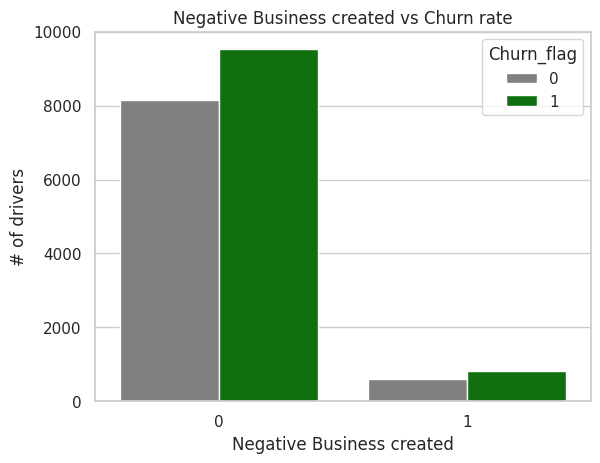

In [242]:
# Creating a barplot to show if there is any significance among the negative business created by a driver and its churn rate

sns.countplot(x= ola['Neg_Bus'], hue=ola['Churn_flag'], palette=["grey", "green"])
plt.xlabel("Negative Business created")
plt.ylabel("# of drivers")
plt.title("Negative Business created vs Churn rate")
plt.show()

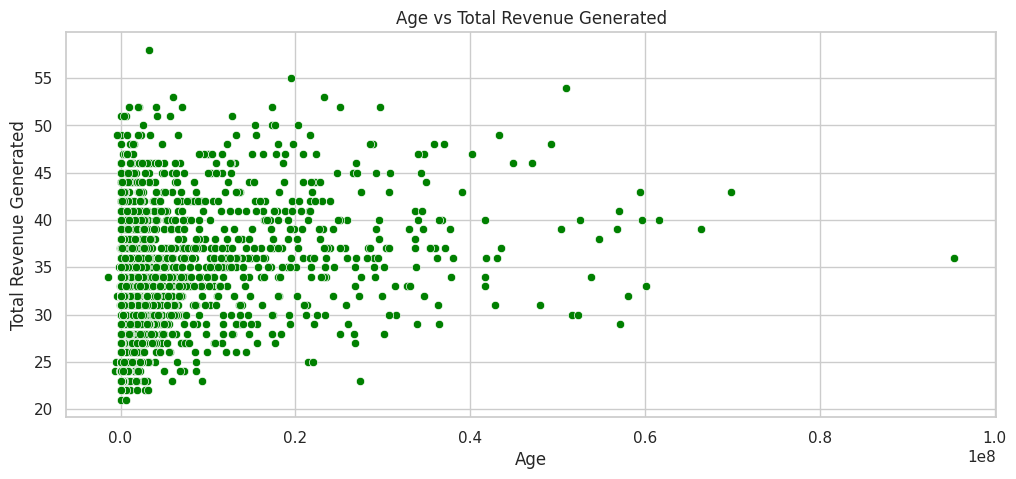

In [243]:
## Scatter plot to show age vs total revenue generated
plt.figure(figsize=(12, 5))
sns.scatterplot(y=ola_df['Age'], x= ola_df['Total_Revenue_acquired'],color="green")
plt.title("Age vs Total Revenue Generated")
plt.xlabel("Age")
plt.ylabel("Total Revenue Generated")
plt.show()

✅ We can infere that the driver geneartes more revenue for the platform in the age group of 30 to 45.

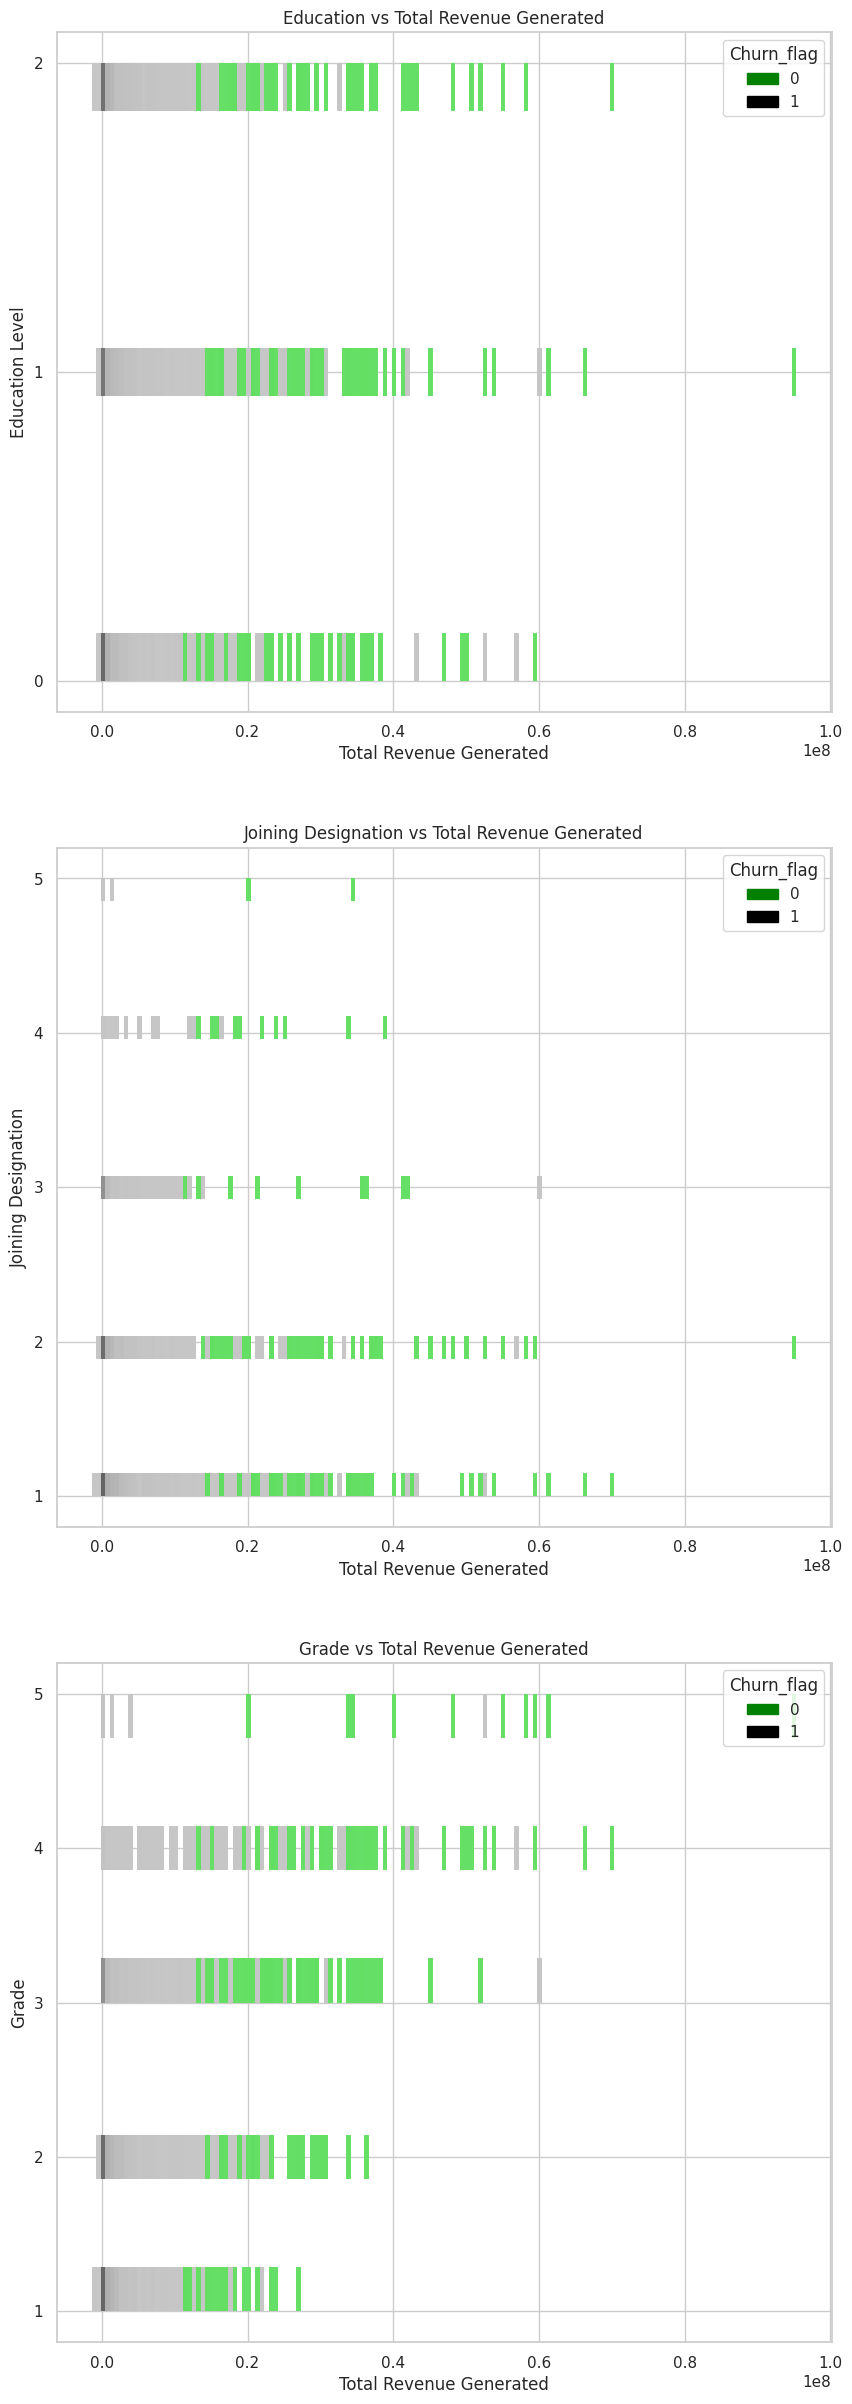

In [244]:
## Education level distribution wrt totalrevenue generated
plt.figure(figsize=(10,30))

plt.subplot(3,1,1)
ax = sns.histplot(y='Education_Level', x= 'Total_Revenue_acquired', palette=["green", "black"], data = ola_df, hue = 'Churn_flag')
plt.title("Education vs Total Revenue Generated")
plt.ylabel("Education Level")
plt.xlabel("Total Revenue Generated")
ax.set_yticks([0, 1, 2])

plt.subplot(3,1,2)
ax = sns.histplot(y='Joining Designation', x= 'Total_Revenue_acquired', palette=["green", "black"], data = ola_df, hue = 'Churn_flag')
plt.title("Joining Designation vs Total Revenue Generated")
plt.ylabel("Joining Designation")
plt.xlabel("Total Revenue Generated")
ax.set_yticks([1,2,3,4,5])

plt.subplot(3,1,3)
ax = sns.histplot(y='Grade', x= 'Total_Revenue_acquired', palette=["green", "black"], data = ola_df, hue = 'Churn_flag')
plt.title("Grade vs Total Revenue Generated")
plt.ylabel("Grade")
plt.xlabel("Total Revenue Generated")
ax.set_yticks([1,2,3,4,5])

plt.show()

💡 We can infere from the above plot that what ever the education background, joining designation or the Grade is of the driver. When the revenue generation increases to the driver the driver churn rate decreases. Hence it is very important to make sure the revenue of the driver has to be increased so we can spend less on hiring the new driver and proportionally we tend to spend less on the hiring process.

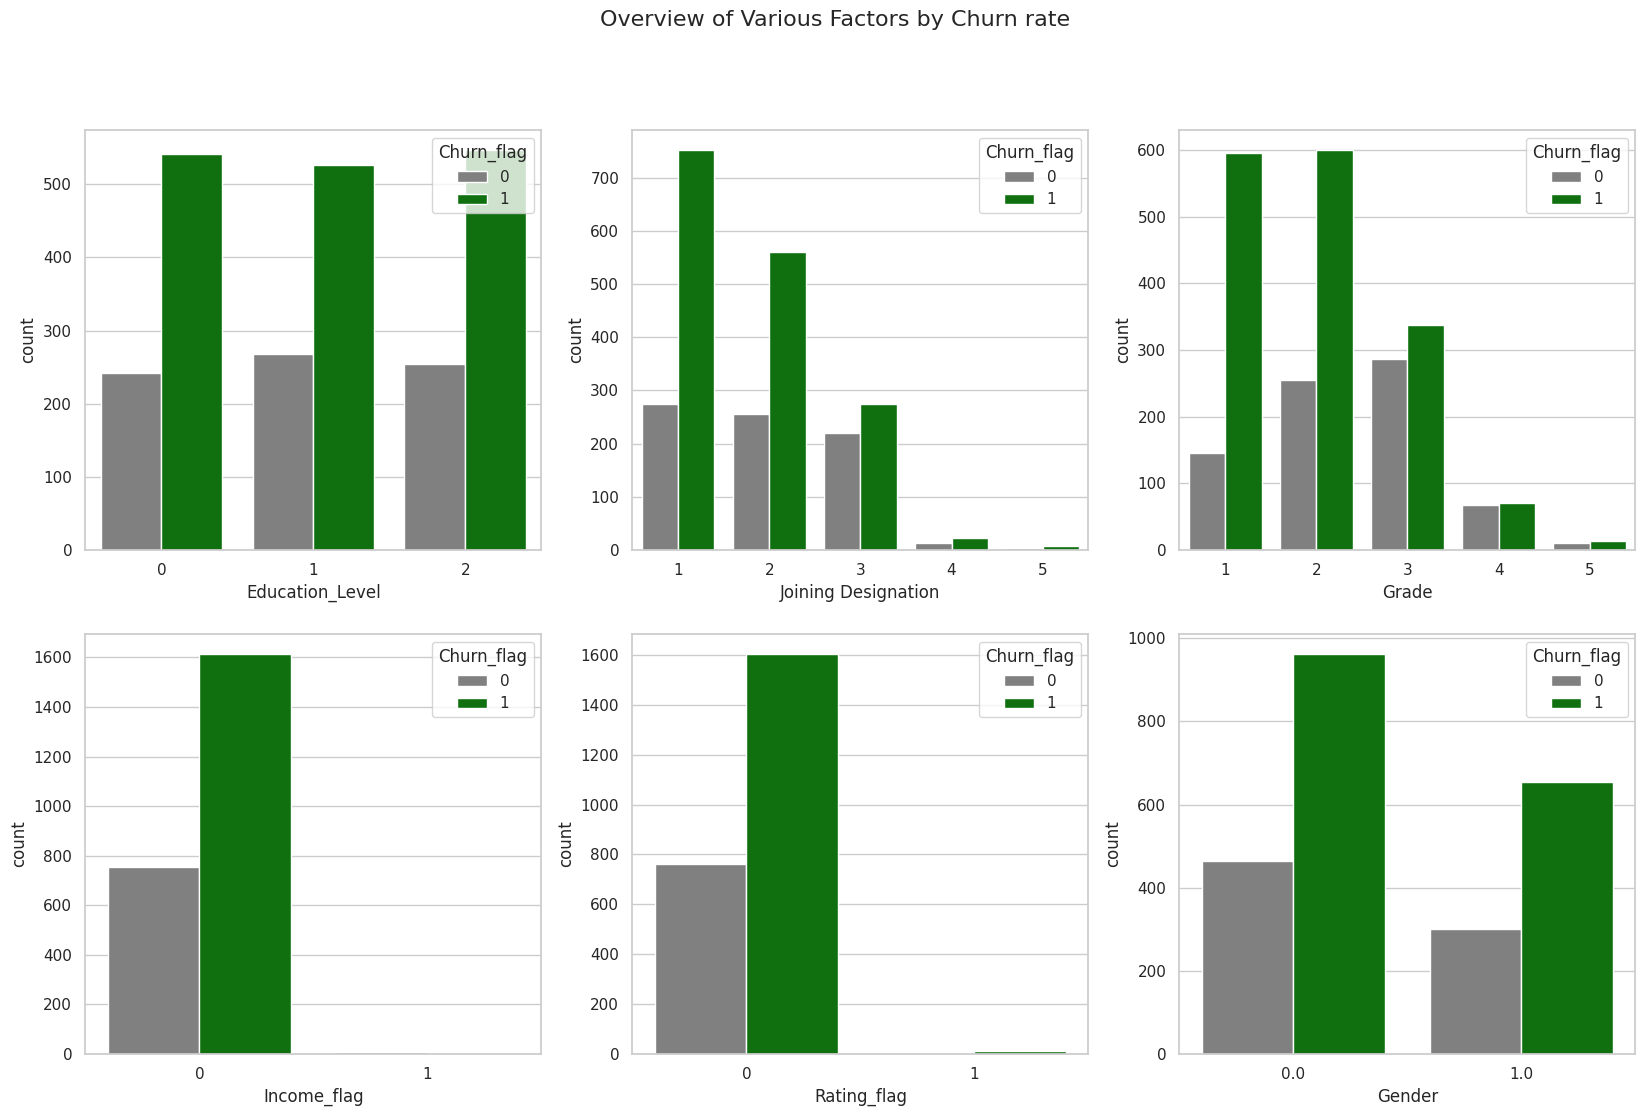

In [245]:
## Generating a Bi-Variate analysis to show the impacting features with respect to Gender


fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle("Overview of Various Factors by Churn rate", fontsize=16)

sns.countplot(ax=axes[0, 0], data=ola_df, x="Education_Level", hue="Churn_flag" , palette=["grey", "green"])
sns.countplot(ax=axes[0, 1], data=ola_df, x="Joining Designation", hue="Churn_flag", palette=["grey", "green"])
sns.countplot(ax=axes[0, 2], data=ola_df, x="Grade", hue="Churn_flag", palette=["grey", "green"])
sns.countplot(ax=axes[1, 0], data=ola_df, x="Income_flag", hue="Churn_flag", palette=["grey", "green"])
sns.countplot(ax=axes[1, 1], data=ola_df, x="Rating_flag", hue="Churn_flag", palette=["grey", "green"])
sns.countplot(ax=axes[1, 2], data=ola_df, x="Gender", hue="Churn_flag", palette=["grey", "green"])

plt.show()

We can infere from the above distributions that the churn rate is high for all the categories. So we have decided to check and analyse more on churn rate now.

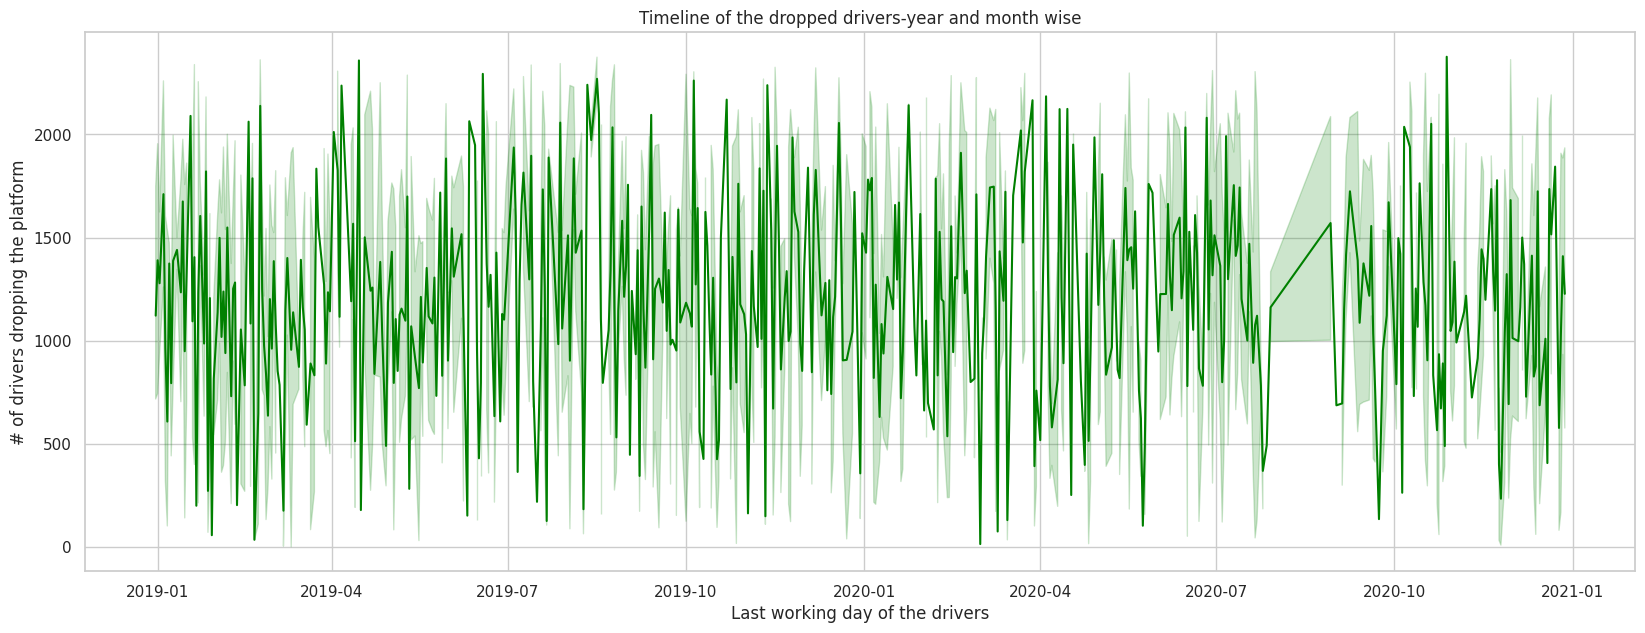

In [246]:
## Line plot to show the trend of drivers being dropped from the platform, on a year and month wise.
plt.figure(figsize = (20,7))
sns.lineplot(data=ola_df, y=ola_df.Driver_ID.index, x="LastWorkingDate", color= "green")
plt.title("Timeline of the dropped drivers-year and month wise")
plt.xlabel("Last working day of the drivers")
plt.ylabel("# of drivers dropping the platform")
plt.show()


We do not see any cyclical or repititive pattern for the drivers leaving the platform. Hence we are assuming a naive way that the drivers just leave the plaform on the fly without any season.

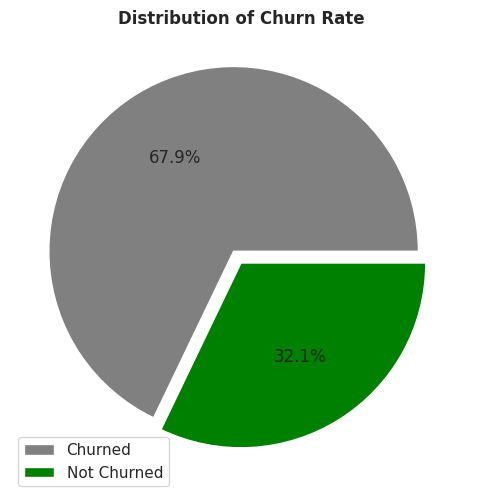

In [247]:
# Driver churn rate percentage distribution
plt.figure(figsize = (10,6))
churn_rate = ola_df['Churn_flag'].map({0: 'Not Churned', 1: 'Churned'}).value_counts()
plt.pie(churn_rate, autopct='%1.1f%%', colors =["grey", "green"], explode = [.075,0])
plt.title('Distribution of Churn Rate', fontweight = 'bold')
plt.legend(churn_rate.index)
plt.show()

❗ We have observed that the churn rate is 67.9% and Non churn rate is 32.1% in this period of two years.

Means the driver's just leaving the platform rate is very very high compared to drivers who stick to the platform.

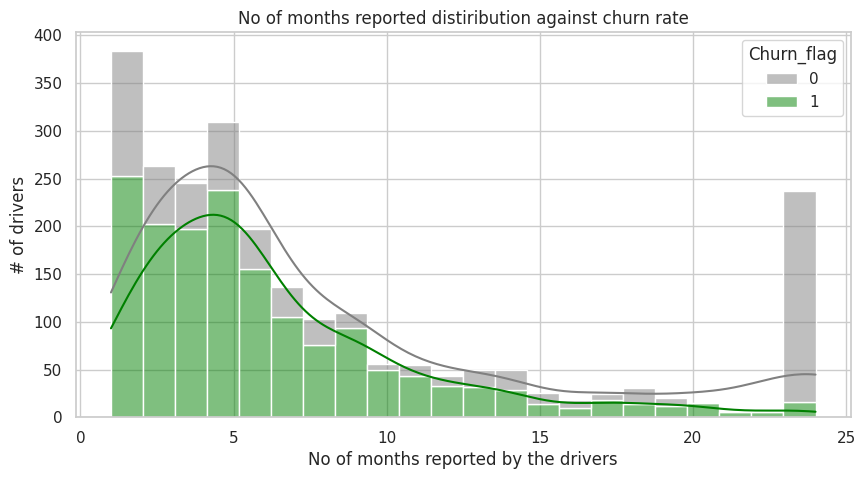

In [248]:
# Plotting a histplot to check the impact of churn rate on the number of months the driver reported

plt.figure(figsize = (10,5))
sns.histplot(data=ola_df, x="No_of_Months_reported", hue="Churn_flag",  multiple="stack", palette=["grey", "green"], kde= True)
plt.title("No of months reported distiribution against churn rate")
plt.xlabel("No of months reported by the drivers")
plt.ylabel("# of drivers")

plt.show()

Since we have data for only two years(ie: 2019 and 2020) we can infere from the above distribution that the drivers, non churn rate is higher when the driver is staying for a very long period of time continously which we can observe for 24 months.

🔆 But to keep the drivers upto 24 months itself looks a challenge as we can observe that, after 9 to 10 months of period the drivers who have enrolled are almost leaving the platform.

▶ We will later perform A/B testing for this to find out the outcome if churn rate is dependent on the total number of months being held in the platform.

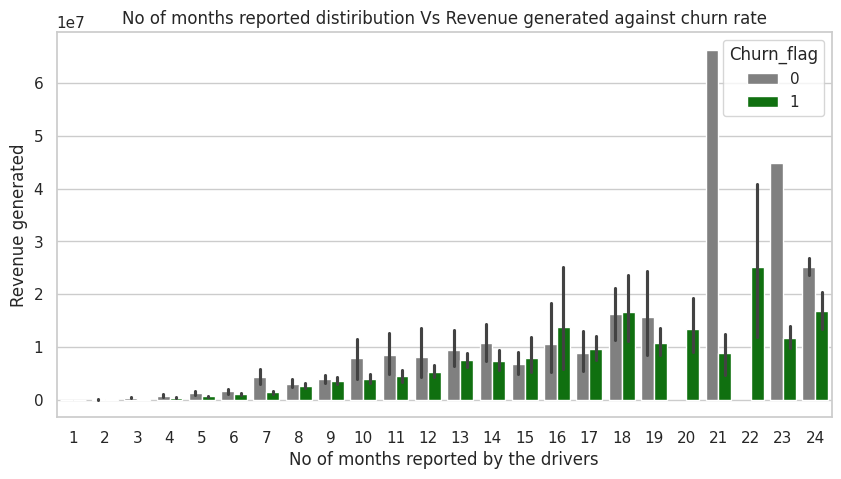

In [249]:
# Plotting a bar graph to check the impact of churn rate on the number of months the driver reported with the revenue generated for the platform.

plt.figure(figsize = (10,5))
sns.barplot( x=ola_df["No_of_Months_reported"], y=ola_df["Total_Revenue_acquired"], hue=ola_df["Churn_flag"], palette=["grey", "green"])
plt.title("No of months reported distiribution Vs Revenue generated against churn rate")
plt.xlabel("No of months reported by the drivers")
plt.ylabel("Revenue generated")

plt.show()

❌ We do not see any significant pattern for churn rate with respect to the number of months a driver reported and revenue generated.
Because if we conclude that the churn rate is reducing with number of months reported by the driver. Then we are wrong, we can see that the churn rate is close to 100% for 20th and 22nd month value.

❎ But we can observe that as more the number of months a driver has reported in the platform more is the revenue the driver has generated to the platform.

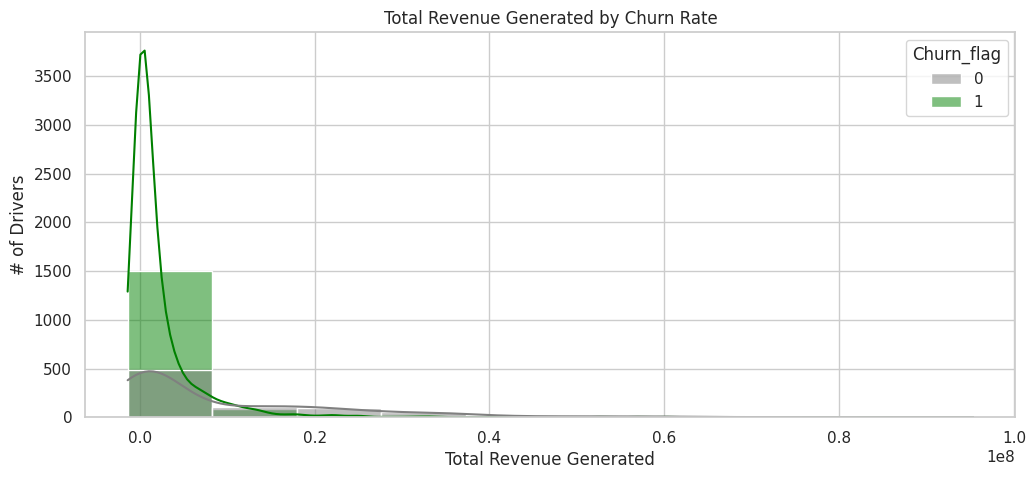

In [250]:
# Creating a histogram of total revenue generated, binned by churn rate.

plt.figure(figsize=(12, 5))
sns.histplot(data=ola_df, x="Total_Revenue_acquired", hue="Churn_flag", bins=10, palette=["grey", "green"], kde=True)
plt.title("Total Revenue Generated by Churn Rate")
plt.xlabel("Total Revenue Generated")
plt.ylabel("# of Drivers")
plt.show()


From the above distribution we can clearly see that when the drivers total revenue acquisition is increasing and if it cross 0.1e8 (ie: 1 cr) business then the churn rate is decreasing.

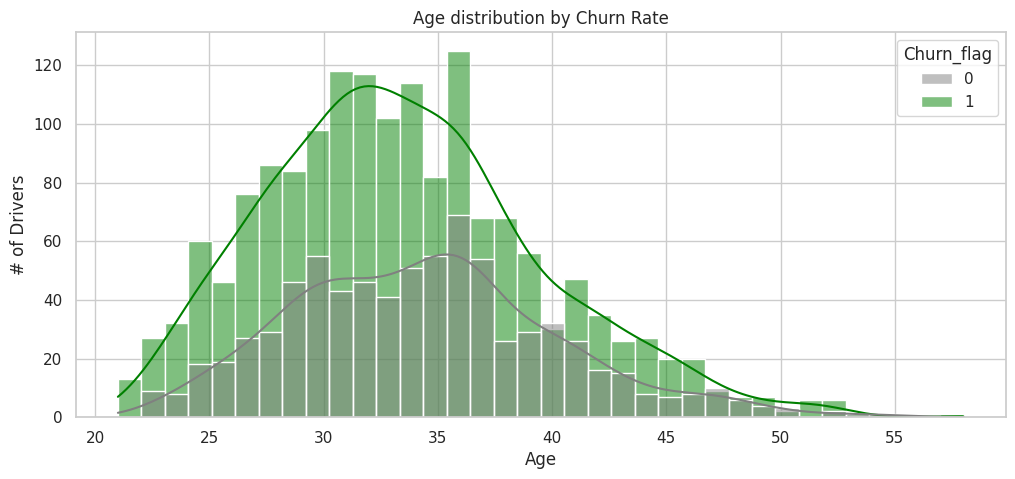

In [251]:
# histplot to check the distribution spread among the age of the drivers.
plt.figure(figsize=(12, 5))
sns.histplot(data = ola_df, x='Age', hue = 'Churn_flag',palette=["grey", "green"], kde=True)
plt.title("Age distribution by Churn Rate")
plt.xlabel("Age")
plt.ylabel("# of Drivers")
plt.show()

There is almost uniform distribution with churn and non churn rate for age groups. So we can not infere with this distribution if there is any reason for churning with respect to the age. We will get this done by A/B testing in the below steps.

**Observations:-**

▶ Majority of the drivers are between the age of 30 and 35.

▶ The drivers with the age 30 to 45 genarate more revenue to the platform.

▶ Drivers who make platform revenue more than 1CR tends not to churn.

▶ There is less churn rate when the drivers are retained for a very long period of time and this makes sense as well.

▶ We haev a dataset of imbalaced target variable. SO we might have to use Oversampling technique to balance it before applying ML models.

▶ There is no significant seasonal pattern observed with respect to drivers churning. They are churning as and when its required.

# Hypothesis **Testing**

In [252]:
# Hypothesis test to validate if there is any significance between age of the driver and the churn rate

# Using ttest_ind as the Age distribution is almost a guassian distribution

from scipy.stats import ttest_ind

'''
H0: There is no significance between age and churn rate
Ha: There is significance between age and churn rate
'''
# Separate age data based on churn_flag
age_churned = ola_df[ola_df['Churn_flag'] == 1]['Age']
age_non_churned = ola_df[ola_df['Churn_flag'] == 0]['Age']

alpha = 0.05

p_val = ttest_ind(age_churned,age_non_churned)[1]

print("P-Value :", p_val)

if p_val < alpha:
    print("There is significance between age and churn rate")
else:
    print("There is no significance between age and churn rate")

P-Value : 0.00028730994597587876
There is significance between age and churn rate


In [253]:
# Hypothesis test to validate if there is any significance between No of months driver reported of the driver and the churn rate

# Using Mann-Whitney U test as the No of months the driver reported distribution is not a normal distribution

from scipy.stats import mannwhitneyu


# Separate No of month's driver reported data based on churn_flag
Mnths_churned = ola_df[ola_df['Churn_flag'] == 1]['No_of_Months_reported']
Mnths_non_churned = ola_df[ola_df['Churn_flag'] == 0]['No_of_Months_reported']

p_val = mannwhitneyu(Mnths_churned,Mnths_non_churned)[1]

print("P-Value :", p_val)

if p_val < alpha:
    print("There is significance between No of months reported and churn rate")
else:
    print("There is no significance between No of months reported and churn rate")

P-Value : 2.864910388311216e-23
There is significance between No of months reported and churn rate


In [254]:
# Hypothesis test to validate if there is any significance between total revenue acquired by a driver and the churn rate

# Using Mann-Whitney U test as the total revenue acquired by a driver distribution is not a normal distribution


# Separate total revenue acquired data based on churn_flag
Revenue_gen_churned = ola_df[ola_df['Churn_flag'] == 1]['Total_Revenue_acquired']
Revenue_gen_non_churned = ola_df[ola_df['Churn_flag'] == 0]['Total_Revenue_acquired']

p_val =mannwhitneyu(Revenue_gen_churned,Revenue_gen_non_churned)[1]

print("P-Value :", p_val)

if p_val < alpha:
    print("There is significance between total revenue acquired and churn rate")
else:
    print("There is no significance between total revenue acquired and churn rate")

P-Value : 2.625202102681489e-46
There is significance between total revenue acquired and churn rate


In [255]:
## Testing to check if there is any significance with respect to the negative business created or not with the churn rate.

# H0: There is significance between negative business and churn rate
# Ha: There is no significance between negative business and churn rate

alpha = 0.05

# Separate negative business data based on churn_flag
neg_bus_churned = ola[ola['Churn_flag'] == 1]['Neg_Bus']
neg_bus_non_churned = ola[ola['Churn_flag'] == 0]['Neg_Bus']

p_val = ttest_ind(neg_bus_churned, neg_bus_non_churned)[1]

print("P-Value :", p_val)

if p_val < alpha:
    print("There is no significance between negative business and churn rate")
else:
    print("There is significance between negative business and churn rate")


P-Value : 0.0007294975787364001
There is no significance between negative business and churn rate


# Preparing the dataframe for Model training

We will be copying the dataframe ola_df into a new dataframe as we will be using the copied data frame for any data adjustment for model preparation.

In [256]:
## copying the dataframe into a new dataframe

ola_df_model = ola_df.copy()

In [257]:
# Using label encoding method to convert City name from categorical tyoe to numberical type.

label_encoder = LabelEncoder()
ola_df_model['City'] = label_encoder.fit_transform(ola_df_model['City'])

In [258]:
ola_df_model.head()

,Reporting_Date,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Income_flag,Rating_flag,No_of_Months_reported,Total_Revenue_acquired,Churn_flag
0,2019-03-01,1,28.0,0.0,15,2,57387,2018-12-24,2019-03-11,1,1,0,0,3,1715580,1
1,2020-12-01,2,31.0,0.0,26,2,67016,2020-11-06,NaT,2,2,0,0,2,0,0
2,2020-04-01,4,43.0,0.0,4,2,65603,2019-12-07,2020-04-27,2,2,0,0,5,350000,1
3,2019-03-01,5,29.0,0.0,28,0,46368,2019-01-09,2019-03-07,1,1,0,0,3,120360,1
4,2020-12-01,6,31.0,1.0,2,1,78728,2020-07-31,NaT,3,3,0,0,5,1265000,0


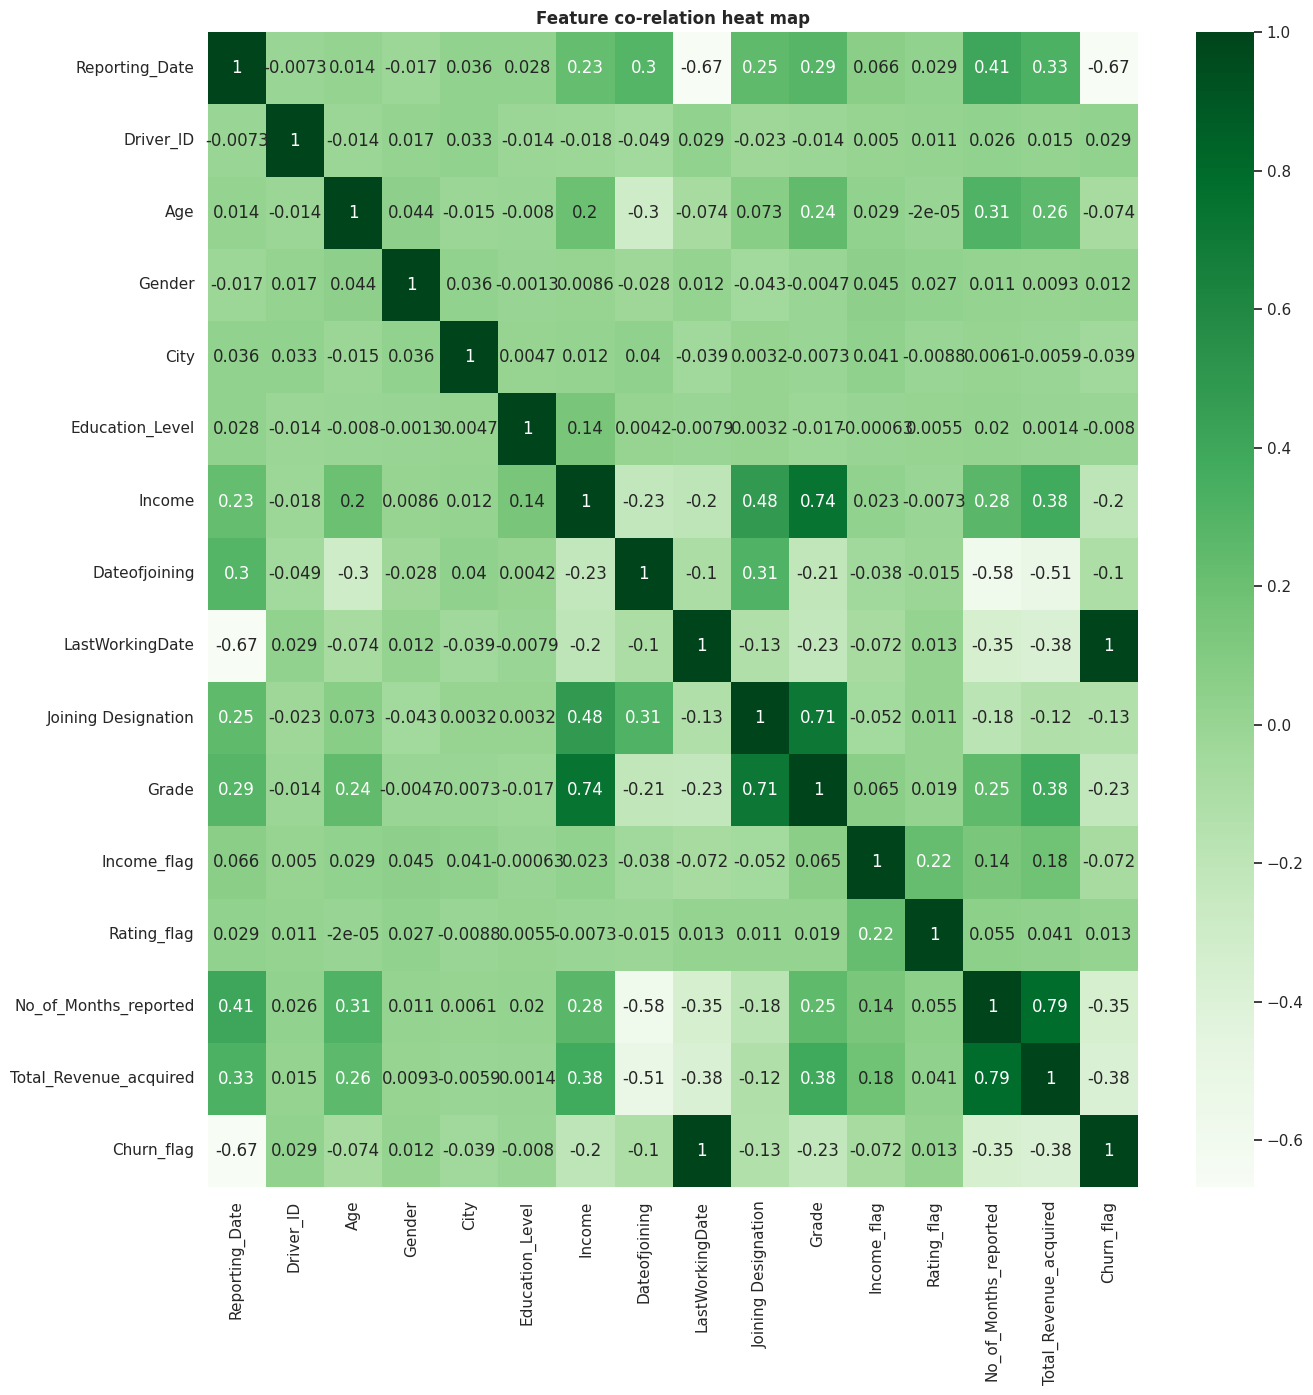

In [259]:
## plotting a heatmap to find out all the features co-relation.

plt.figure(figsize=(15, 15))
sns.heatmap(ola_df_model.corr(), annot=True, cmap="Greens")
plt.title("Feature co-relation heat map", fontweight = 'bold')
plt.show()

**Observation-**

▶ The features 'Income' and 'Grade' very much positively co-related.

▶ The features 'Joining designation' and 'Grade' are also positively co-related.

▶ 'Total Revenue acquired' is positively co-related with 'No of months reported' feature. Which also makes sense as the duration for whicht he driver reports have good revenue rgenerated for the platform.

▶ 'Joining designation' is postively co-related with 'Income'. This also makes sense as the designation is higher the income also would be higher.

▶ 'Age' is positively co-related with 'No of months reported'.

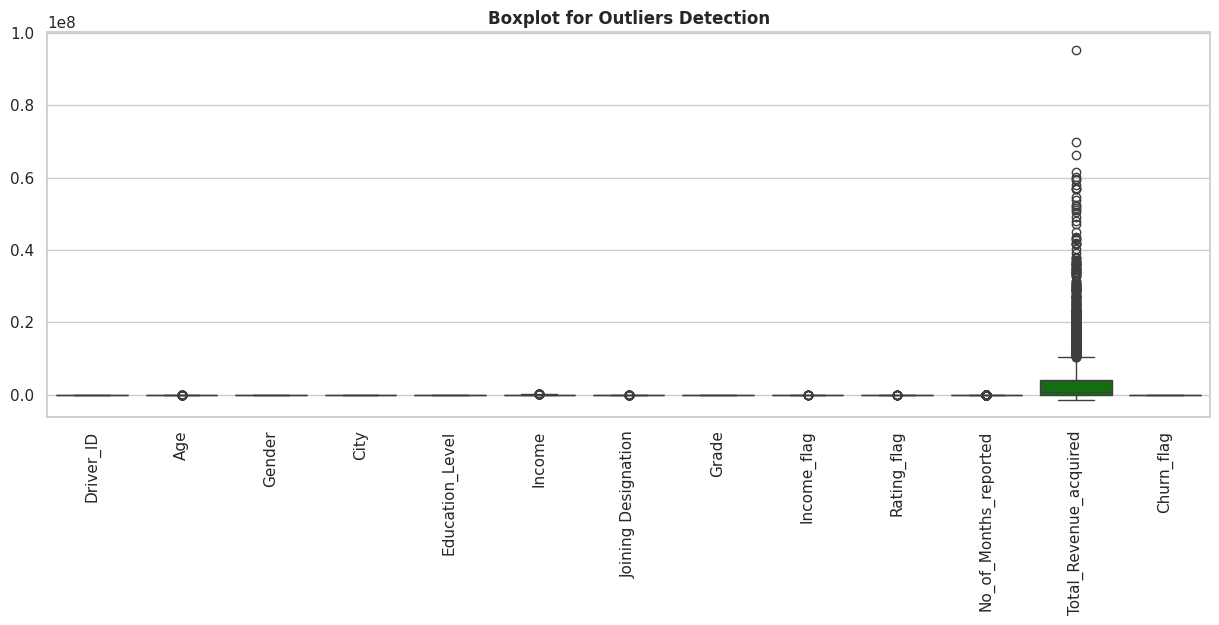

In [260]:
# generating a boxplot for the entire dataframe of ola_df_model to check for outliers

plt.figure(figsize=(15, 5))
sns.boxplot(data=ola_df_model, color= "green")
plt.title("Boxplot for Outliers Detection", fontweight = 'bold')
plt.xticks(rotation = 90)
plt.show()


There are no much outliers among other features and we find outlier only in the feature 'Total Revenue generated' this may be due to a lot of positive and negetive imbalace. Which could be considered as okay for model building purpose

In [261]:
# we can drop some unnecessary columns or repeated features for the purpose of model building

ola_df_model.drop(['Driver_ID', 'LastWorkingDate', 'Reporting_Date', 'Dateofjoining'], axis=1, inplace=True)

In [262]:
ola_df_model.columns

Index(['Age', 'Gender', 'City', 'Education_Level', 'Income',
       'Joining Designation', 'Grade', 'Income_flag', 'Rating_flag',
       'No_of_Months_reported', 'Total_Revenue_acquired', 'Churn_flag'],
      dtype='object')

In [263]:
# splitting the data with independent features and dependent feature for model building purpose
x= ola_df_model.drop('Churn_flag', axis=1)
y= ola_df_model['Churn_flag']

**Applying SMOTE method to balance the imbalaced data : for better resurgence in model building**

In [264]:
# since our dataframe is imbalaced with target variable we will use synthetic oversampling method SMOTE to balace them

print("Before SMOTE")
print(ola_df_model['Churn_flag'].value_counts())
print()
smt = SMOTE(random_state=42)

x_smt, y_smt = smt.fit_resample(x, y)
print()
print("After SMOTE")
print(y_smt.value_counts())


Before SMOTE
Churn_flag
1    1616
0     765
Name: count, dtype: int64


After SMOTE
Churn_flag
1    1616
0    1616
Name: count, dtype: int64


**Scaling the oversampled data for model training**

In [265]:
# creating scaler object for scaled data and then fit transform our SMOTE independent features data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_smt)

In [266]:
x_scaled

array([[-1.0656931 , -0.85297197,  0.11389094, ..., -0.07053456,
        -0.77801005, -0.40912305],
       [-0.53378226, -0.85297197,  1.51156112, ..., -0.07053456,
        -0.90902966, -0.57230962],
       [ 1.59386109, -0.85297197, -1.28377925, ..., -0.07053456,
        -0.51597081, -0.5390175 ],
       ...,
       [-0.31247685, -0.05320155,  1.25743927, ..., -0.07053456,
        -1.04004928, -0.57230962],
       [ 0.76944684,  0.81920875,  0.49507371, ..., -0.07053456,
        -0.51597081, -0.37164877],
       [-0.17917503,  0.45386528, -0.26729184, ..., -0.07053456,
         1.97340189,  0.51010348]])

# ML model training and building

In [267]:
#performing independent and dependent features with train test data split
x_test, x_train, y_test, y_train = train_test_split(x_scaled, y_smt, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((647, 11), (2585, 11), (647,), (2585,))

**The trade off-**

We need to have a lower FN(False Negetive) cases (Recall) in this business model as the cost to retain an exisitng driver is lesser compared to getting/hiring a new driver.

We need to have lower FP(False Positive) cases (Precision) as well, because simply predicting a driver to be churned and in actual he wont churn then we need to spend a lot of unnecessay money on someone who is already happy.

Hence in this case we can opt for F-2 score as model evaluation metric.

**Logistic Regression**

In [268]:
# starting with logistic regression.

# creating logistic regression model
LR = LogisticRegression()
LR.fit(x_train, y_train)
LR_y_pred = LR.predict(x_test)
print("The classification report for Vanilla Logistic regression is:\n\n", classification_report(y_test, LR_y_pred))

The classification report for Vanilla Logistic regression is:

               precision    recall  f1-score   support

           0       0.71      0.59      0.64      1290
           1       0.65      0.76      0.70      1295

    accuracy                           0.67      2585
   macro avg       0.68      0.67      0.67      2585
weighted avg       0.68      0.67      0.67      2585



In [269]:
## calculating the accuracy score of the logistic regression built model

LR_acc = accuracy_score(y_test, LR_y_pred)
LR_acc

0.6735009671179883

The accuracy score of the vanilla Logistic regression model is 0.6735.
Hence we will check with other metric of f-2 beta score as we decided with the trade-off metric.

In [270]:
print("The training data accuracy for Logistic Regression model", LR.score(x_train, y_train))
print("The test data accuracy for for Logistic Regression mode", LR.score(x_test, y_test))

The training data accuracy for Logistic Regression model 0.6754250386398764
The test data accuracy for for Logistic Regression mode 0.6735009671179883


The confusion matrix of Vanilla Logistic regression model:



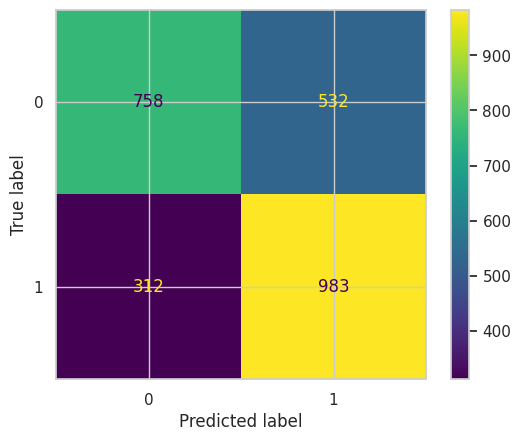

In [271]:
## Confusion matric of Logistic regression model

print("The confusion matrix of Vanilla Logistic regression model:\n")
ConfusionMatrixDisplay(confusion_matrix(y_test, LR_y_pred)).plot()
plt.show()

In [272]:
# finding the F-2 beta score for the logistic regression model:

LR_f2_score = fbeta_score(y_test, LR_y_pred, beta=2)
print(f"The f2-beta score for Vanilla Logistic Regression is: {LR_f2_score}")

The f2-beta score for Vanilla Logistic Regression is: 0.7341299477221807


We are getting a score of 0.73 with the help of simple logistic regression model.

We will further use the same data for different ensemble techniques like Random Forest, GBDT and XGboost and check what score we will be getting using those models and pick a good model for further consideration.

Trying with Naive Baye's algorithm to see if there is any significant improvement:

In [273]:
# training a naive bayes algorithm on the ola data to find the predictions


# Create an instance of the GaussianNB classifier with Laplace smoothing to handle features with values as 0.
clf_nb = GaussianNB(var_smoothing=1e-9)
clf_nb.fit(x_train, y_train)
y_nb_pred = clf.predict(x_test)

nb_accuracy = accuracy_score(y_test, y_nb_pred)
nb_f2_score = fbeta_score(y_test, y_nb_pred, beta=2)

print("Accuracy Score of Naive Baye's algorithm:", nb_accuracy)
print("F2 Score of Naive Baye's algorithm:", nb_f2_score)


Accuracy Score of Naive Baye's algorithm: 0.5013539651837524
F2 Score of Naive Baye's algorithm: 0.009626492106276472


We see that the results from Nave Baye's algorithm are very very bad so we will not be considering this algorithm as well for any further tuning.

We will proceed to check the results from Ensemble methods...

**Ensemble Method:**

> **Ensemble method: Bagging- Random Forest**



In [274]:
# Trying out ensemble bagging method: Random Forset algorithm


RFC = RandomForestClassifier(random_state=42) #training the random forest algorithm
RFC.fit(x_train, y_train)
RF_y_pred = RFC.predict(x_test) #running random forest algorithm on the test data to predict y
RF_f2_score = fbeta_score(y_test, RF_y_pred, beta=2)
print("The classification report for Vanilla random forest algorithm is:\n\n", classification_report(y_test, RF_y_pred))
print()
print("f-2 beta score for Vanilla Random forest alorithm is: ",RF_f2_score)

The classification report for Vanilla random forest algorithm is:

               precision    recall  f1-score   support

           0       0.79      0.73      0.76      1290
           1       0.75      0.81      0.78      1295

    accuracy                           0.77      2585
   macro avg       0.77      0.77      0.77      2585
weighted avg       0.77      0.77      0.77      2585


f-2 beta score for Vanilla Random forest alorithm is:  0.7989965029648776


In [275]:
## Checking on the important features/ the features which give more weightage on the model training and accuracy score

feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': RFC.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                   Feature  Importance
9    No_of_Months_reported    0.216336
4                   Income    0.174223
10  Total_Revenue_acquired    0.172739
0                      Age    0.132885
2                     City    0.112834
1                   Gender    0.068843
3          Education_Level    0.042778
5      Joining Designation    0.039304
6                    Grade    0.038040
7              Income_flag    0.001175
8              Rating_flag    0.000842


Hence we can find that with vanilla RFC the fetures which gives more weigtage for the model training are: No_of_Months_reported, Income, Total_Revenue_acquired followed by Age and City. And the other features does not give much importance in prediction of target independent variable.

In [276]:
print("The training data accuracy for Random Forest before hyper parameter tuning", RFC.score(x_train, y_train))
print("The test data accuracy for Random Forest after before parameter tuning", RFC.score(x_test, y_test))

The training data accuracy for Random Forest before hyper parameter tuning 1.0
The test data accuracy for Random Forest after before parameter tuning 0.7717601547388782


The confusion matrix of Random Forest model without hyper parameters:



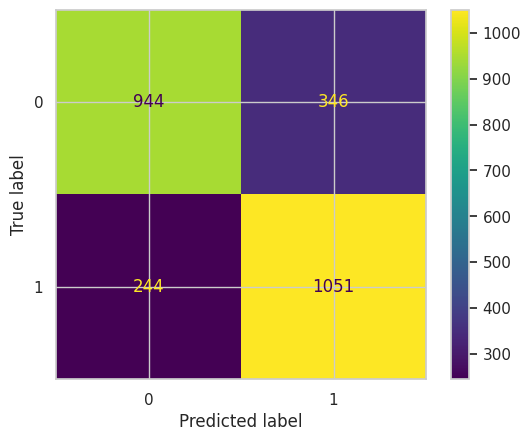

In [277]:
## Confusion matric of  Random Forest algorithm without any hyperparameters

print("The confusion matrix of Random Forest model without hyper parameters:\n")
ConfusionMatrixDisplay(confusion_matrix(y_test, RF_y_pred)).plot()
plt.show()

❎ The accuracy has increased with Vanilla Random forest alorithm compared to the Logistic regression. The accuracy score now is 0.77.

❎ The f-2 beta score for vanilla random forst algorithm is 0.7989.

⏏ We will try with different parameters and perform hyper parameter tuning with this particular ensemble method and try to increase its accuracy and f-2 beta scores.

We see that the training accuracy is 1.0 and test accuracy is 0.77, which clearly indicates that the training data is overfitting and which is not good for a model to face new data. Hence we will try to reduce the overfitting by trying with different hyper paarameters and searching for the best parameters and then trainign the model with those parameters.

In [278]:
# Defining parameters for hyperparameter tuning for Random forest-

RF_params = {
          'n_estimators' : [25, 50,100,200],
          'max_depth' : [3,5,10],
          'criterion' : ['gini', 'entropy'],
          'bootstrap' : [True, False],
          'max_features' : [8,9,10,11]
         }

In [335]:
# # ## running the grid search cross validation matrix accross all the above provided parameters:

# f2_scorer = make_scorer(fbeta_score, beta=2)
# RFC_grid_search = GridSearchCV(estimator=RFC, param_grid=RF_params, cv=5, scoring=f2_scorer, n_jobs=-1)

# RFC_grid_search.fit(x_train, y_train) # training all the parameters defined to the new model

In [280]:
# # finidng the best parameters among the given parameters by keeping f2-beta score as the metric

# RFC_grid_search.best_params_

When we ran the grid search CV for the Vanilla Random Forst algorithm we got the below parameters as the best parameters to run to have higher recall and lower precision scores.

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 10,
 'n_estimators': 50}

 Hence we would be applying these to the new Random Forest algorithm and train the model to get best accuracy scores.

If we want to reduce the time taken by grid search CV then,
we can also use much more parameters and use RandomizedGridSearchCV method. Which will provide the best parameters randomly.

Now training the model with the best parametrs found from the GridSearchCV and predicting the target independent variable.

In [281]:
# New RF model to train after hyper parameter tuning.
RFC1 = RandomForestClassifier(bootstrap=True, criterion='entropy', max_depth=3, max_features=10, n_estimators=50, random_state=42)
RFC1.fit(x_train, y_train)
RFC1_y_pred = RFC1.predict(x_test)
RF1_f2_score = fbeta_score(y_test, RFC1_y_pred, beta=2)
print("The classification report of Random Forest algorithm after hyper parameter tuning:\n\n",classification_report(y_test, RFC1_y_pred))
print("The f2-beta score of Ramdom Forst algorithm after hyper parameter tuning:",RF1_f2_score)

The classification report of Random Forest algorithm after hyper parameter tuning:

               precision    recall  f1-score   support

           0       0.79      0.56      0.65      1290
           1       0.66      0.86      0.74      1295

    accuracy                           0.71      2585
   macro avg       0.73      0.71      0.70      2585
weighted avg       0.73      0.71      0.70      2585

The f2-beta score of Ramdom Forst algorithm after hyper parameter tuning: 0.8073447974351501


In [282]:
print("The training data accuracy for Random Forest after hyper parameter tuning", RFC1.score(x_train, y_train))
print("The test data accuracy for Random Forest after hyper parameter tuning", RFC1.score(x_test, y_test))

The training data accuracy for Random Forest after hyper parameter tuning 0.7310664605873262
The test data accuracy for Random Forest after hyper parameter tuning 0.7056092843326885


The confusion matrix of Random Forest model after hyper parameter tuning:



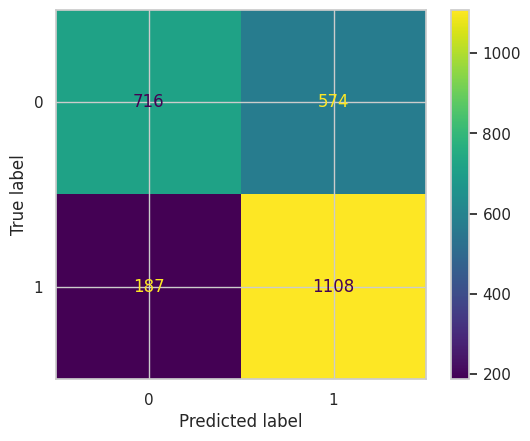

In [283]:
## Confusion matric of  Random Forest model after hyper parameter tuning

print("The confusion matrix of Random Forest model after hyper parameter tuning:\n")
ConfusionMatrixDisplay(confusion_matrix(y_test, RFC1_y_pred)).plot()
plt.show()

Hence after hyper parameter tuning we could observe that the f2-beta score has been increased to 0.8073, with not that much improvement compared to Vanilla Random Forst f2-beta score of 0.7989.

**Fining feature importance and re-building and re-training the model on new dataframe with important features only**

In [284]:
## Checking on the important features/ the features which give more weightage on the model training and accuracy score

feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': RFC1.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                   Feature  Importance
9    No_of_Months_reported    0.681741
4                   Income    0.120720
10  Total_Revenue_acquired    0.092485
1                   Gender    0.024281
5      Joining Designation    0.021979
2                     City    0.019540
6                    Grade    0.017815
0                      Age    0.016479
3          Education_Level    0.004430
7              Income_flag    0.000531
8              Rating_flag    0.000000


Hence we can find that with Hyper parameter tuned RFC the fetures which gives more weigtage for the model training are: No_of_Months_reported and Income. And the other features does not give much importance in prediction of target independent variable.

Income_flag and Rating_flag gives close to zero importance for model's target variable prediction.

Now we will be removing the features from the dataframe which does not give more weightage for model prediction and use only those features which gives weightage and then train a new model to check the performance:

In [285]:
# splitting the data with independent features and dependent feature for building a better model with better accuracy
x_rf= ola_df_model.drop(columns = ['Churn_flag', 'Rating_flag', 'Income_flag', 'Education_Level'], axis=1)
y_rf= ola_df_model['Churn_flag']

In [286]:
# since our new dataframe is imbalaced as well , with target variable we will use synthetic oversampling method SMOTE to balance them

print("Before SMOTE")
print(y_rf.value_counts())
print()
smt = SMOTE(random_state=42)

x_smt_rf, y_smt_rf = smt.fit_resample(x_rf, y_rf)
print()
print("After SMOTE")
print(y_smt_rf.value_counts())

Before SMOTE
Churn_flag
1    1616
0     765
Name: count, dtype: int64


After SMOTE
Churn_flag
1    1616
0    1616
Name: count, dtype: int64


In [287]:
## Standard scaling the new data
SS_rf = StandardScaler()
x_rf_scaled = SS_rf.fit_transform(x_rf)

In [288]:
#performing independent and dependent features with train test data split
x_rf_test, x_rf_train, y_rf_test, y_rf_train = train_test_split(x_rf_scaled, y_rf, test_size=0.2, random_state=42)
x_rf_train.shape, x_rf_test.shape, y_rf_train.shape, y_rf_test.shape

((477, 8), (1904, 8), (477,), (1904,))

In [289]:
#Training the model on the new dataframe of important features and predicting the
RFC2 = RandomForestClassifier(bootstrap=True, criterion='entropy', max_depth=3, max_features=4, n_estimators=50, random_state=42)
RFC2.fit(x_rf_train, y_rf_train)
RFC2_y_pred = RFC2.predict(x_rf_test)
RF2_f2_score = fbeta_score(y_rf_test, RFC2_y_pred, beta=2)
print("The classification report of Random Forest algorithm after hyper parameter tuning:\n\n",classification_report(y_rf_test, RFC2_y_pred))
print("The f2-beta score of Ramdom Forst algorithm after hyper parameter tuning:",RF2_f2_score)

The classification report of Random Forest algorithm after hyper parameter tuning:

               precision    recall  f1-score   support

           0       0.94      0.30      0.46       615
           1       0.75      0.99      0.85      1289

    accuracy                           0.77      1904
   macro avg       0.85      0.65      0.66      1904
weighted avg       0.81      0.77      0.73      1904

The f2-beta score of Ramdom Forst algorithm after hyper parameter tuning: 0.9312153890993878


The confusion matrix of Random Forest model after hyper parameter tuning:



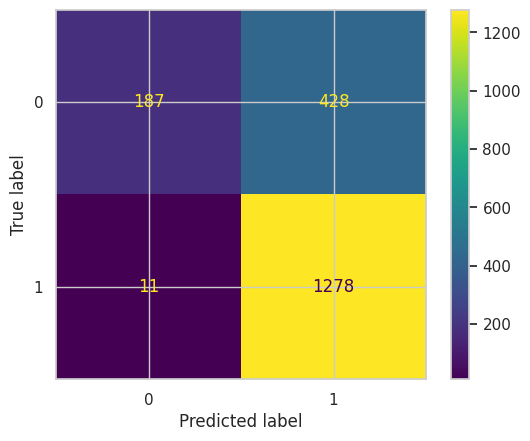

In [290]:
## Confusion matric of  Random Forest without any hyperparameters

print("The confusion matrix of Random Forest model after hyper parameter tuning:\n")
ConfusionMatrixDisplay(confusion_matrix(y_rf_test, RFC2_y_pred)).plot()
plt.show()

As we can see that the F2-score has drastically increased from 0.79 to 0.93 after a series of good steps like: hyper parameter tuning, feature selection and then then re-building and re-training the ML model. Which eventually is giving better results.



> **Ensemble Method: Boosting:-- Gradient boosting classifier**



In [291]:
# Trying out ensemble boosting method: Gradient boosting classifier algorithm

GBC = GradientBoostingClassifier(random_state=42)
GBC.fit(x_train, y_train)
GBC_y_pred = GBC.predict(x_test)
GBC_f2_score = fbeta_score(y_test, GBC_y_pred, beta=2)
print("The classification report for Gradient boosting classifier algorithm is:\n\n", classification_report(y_test, GBC_y_pred))
print()
print("f-2 beta score for for Gradient boosting classifier algorithm is: ",GBC_f2_score)

The classification report for Gradient boosting classifier algorithm is:

               precision    recall  f1-score   support

           0       0.81      0.71      0.76      1290
           1       0.75      0.84      0.79      1295

    accuracy                           0.78      2585
   macro avg       0.78      0.78      0.78      2585
weighted avg       0.78      0.78      0.78      2585


f-2 beta score for for Gradient boosting classifier algorithm is:  0.8177570093457943


In [292]:
print("The training data accuracy for Gradient boosting classifier algorithm before hyper paarmeter tuning is:", GBC.score(x_train, y_train))
print("The test data accuracy for Gradient boosting classifier algorithm before hyper paarmeter tuning is:", GBC.score(x_test, y_test))

The training data accuracy for Gradient boosting classifier algorithm before hyper paarmeter tuning is: 0.9211746522411128
The test data accuracy for Gradient boosting classifier algorithm before hyper paarmeter tuning is: 0.7760154738878143


The confusion matrix of Gradient boosting classifier without any hyperparameters:



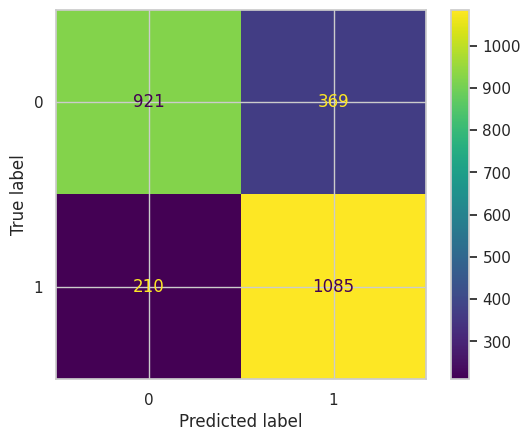

In [293]:
## Confusion matric of Gradient boosting classifier without any hyperparameters

print("The confusion matrix of Gradient boosting classifier without any hyperparameters:\n")
ConfusionMatrixDisplay(confusion_matrix(y_test, GBC_y_pred)).plot()
plt.show()

In [294]:
# Defining parameters for hyperparameter tuning of GBC-

GBC_params = {
    "n_estimators": [i for i in range(100, 500, 50)],
    "learning_rate": [0.001, 0.05 ,0.075, 0.09, 0.1],
    "max_depth" : [2, 3, 4, 5, 7],
    "max_leaf_nodes" : [5, 10,20, 40, 80],
    "learning_rate": [0.001, 0.05 ,0.075, 0.09, 0.1]
}

Training the model by running on different paarameters and perform GridSearchCV

In [334]:
# # Building a new GBC model to have all defined paarmeters trained and find the best parameters
# f2_scorer = make_scorer(fbeta_score, beta=2)
# GBC_GridSearchCV = GridSearchCV(GBC, param_grid=GBC_params, scoring = f2_scorer, cv=3, n_jobs = -1, verbose = 1)

# GBC_GridSearchCV.fit(x_train, y_train) # training all the parameters defined to the new model


In [296]:
# ## # finidng the best parameters among the given parameters by keeping f2-beta score as the metric
# GBC_GridSearchCV.best_params_

When we ran the grid search CV for the Vanilla Gradient boosting classification algorithm we got the below parameters as the best parameters to have higher recall and lower precision scores.

{'learning_rate': 0.1,
 'max_depth': 4,
 'max_leaf_nodes': 10,
 'n_estimators': 200}

Hence we would be applying these to the new Gradient boosting classification  algorithm and train the model to get best accuracy scores.

In [297]:
GBC1 = GradientBoostingClassifier(learning_rate=0.1, max_depth=4, max_leaf_nodes=10, n_estimators=200, random_state=0)
GBC1.fit(x_train, y_train)
GBC1_y_pred = GBC1.predict(x_test)
GBC1_f2_score = fbeta_score(y_test, GBC1_y_pred, beta=2)

In [298]:
print("The training data accuracy for Gradient boosting classifier algorithm after 1st hyper paartemet tuning is:", GBC1.score(x_train, y_train))
print("The test data accuracy for Gradient boosting classifier algorithm after 1st hyper paartemet tuning is:", GBC1.score(x_test, y_test))

The training data accuracy for Gradient boosting classifier algorithm after 1st hyper paartemet tuning is: 0.9969088098918083
The test data accuracy for Gradient boosting classifier algorithm after 1st hyper paartemet tuning is: 0.7644100580270793


In [299]:
print("The classification report for Gradient boosting classifier algorithm after 1st hyper paartemet tuning is:\n\n", classification_report(y_test, GBC1_y_pred))
print()
print("f-2 beta score for for Gradient boosting classifier algorithm after 1st hyper paartemet tuning is: ",GBC1_f2_score)

The classification report for Gradient boosting classifier algorithm after 1st hyper paartemet tuning is:

               precision    recall  f1-score   support

           0       0.79      0.72      0.75      1290
           1       0.74      0.81      0.78      1295

    accuracy                           0.76      2585
   macro avg       0.77      0.76      0.76      2585
weighted avg       0.77      0.76      0.76      2585


f-2 beta score for for Gradient boosting classifier algorithm after 1st hyper paartemet tuning is:  0.7972112761442862


In [332]:
# ## Since the f-2 score has decreased we will perform the randomised grid search cv with mode number of cross validations: to perform much better

# f2_scorer = make_scorer(fbeta_score, beta=2)
# GBC_RandomizedSearchCV = RandomizedSearchCV(GBC1, param_distributions=GBC_params, scoring = f2_scorer, cv=5, n_jobs = -1, verbose = 1)

# GBC_RandomizedSearchCV.fit(x_train, y_train) # training all the parameters defined to the new model

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(max_depth=4,
                                                        max_leaf_nodes=10,
                                                        n_estimators=200,
                                                        random_state=0),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.05, 0.075,
                                                          0.09, 0.1],
                                        'max_depth': [2, 3, 4, 5, 7],
                                        'max_leaf_nodes': [5, 10, 20, 40, 80],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 450]},
                   scoring=make_scorer(fbeta_score, beta=2), verbose=1)

In [301]:
# GBC_RandomizedSearchCV.best_params_

In [302]:
GBC2 = GradientBoostingClassifier(learning_rate=0.15, max_depth=1, max_leaf_nodes=2, n_estimators=269)
GBC2.fit(x_train, y_train)
GBC2_y_pred = GBC2.predict(x_test)
GBC2_f2_score = fbeta_score(y_test, GBC2_y_pred, beta=2)

In [303]:
print("The training data accuracy for Gradient boosting classifier algorithm after 2nd hyper paarmeter tuning is:", GBC2.score(x_train, y_train))
print("The test data accuracy for Gradient boosting classifier algorithm after 2nd hyper paarmeter tuning is:", GBC2.score(x_test, y_test))
print()
print("The classification report for Gradient boosting classifier algorithm after 2nd hyper paarmeter tuning is:\n\n", classification_report(y_test, GBC2_y_pred))
print()
print("f-2 beta score for for Gradient boosting classifier algorithm after 2nd hyper paarmeter tuning is: ",GBC2_f2_score)

The training data accuracy for Gradient boosting classifier algorithm after 2nd hyper paarmeter tuning is: 0.7867078825347759
The test data accuracy for Gradient boosting classifier algorithm after 2nd hyper paarmeter tuning is: 0.7644100580270793

The classification report for Gradient boosting classifier algorithm after 2nd hyper paarmeter tuning is:

               precision    recall  f1-score   support

           0       0.82      0.68      0.74      1290
           1       0.73      0.85      0.78      1295

    accuracy                           0.76      2585
   macro avg       0.77      0.76      0.76      2585
weighted avg       0.77      0.76      0.76      2585


f-2 beta score for for Gradient boosting classifier algorithm after 2nd hyper paarmeter tuning is:  0.8221326164874553


The confusion matrix of Gradient boosting classifier after  2nd hyperparameter tuning:



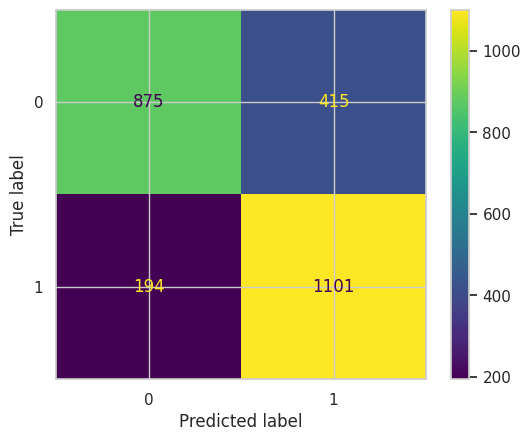

In [304]:
## Confusion matric of Gradient boosting classifier after hyperparameter tuning

print("The confusion matrix of Gradient boosting classifier after  2nd hyperparameter tuning:\n")
ConfusionMatrixDisplay(confusion_matrix(y_test, GBC2_y_pred)).plot()
plt.show()

We have got an f-2 score of 0.822 after hyper paarameter tuning, while before the tuning it was 0.817. So with this much improvement also we can confirm that the model will predict less FP and give weghtage for FN instead.
In this course of parameter selection we can observe that the TP rate has drastically increased there by reducing FP rate. Which can be considered as a healthy decision in parameter tuning and running them with those parameters.

In [305]:
## Checking on the important features / the features which give more weightage on the model training and accuracy score

feature_importance_df_XGB = pd.DataFrame({
    'Feature': x.columns,
    'Importance': GBC2.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df_XGB)

                   Feature  Importance
9    No_of_Months_reported    0.464046
1                   Gender    0.189106
10  Total_Revenue_acquired    0.135712
4                   Income    0.104539
5      Joining Designation    0.035839
6                    Grade    0.029537
0                      Age    0.022775
3          Education_Level    0.008336
2                     City    0.005908
8              Rating_flag    0.004202
7              Income_flag    0.000000


In [306]:
# splitting the data with independent features and dependent feature for building a better model with better accuracy
x_gb = ola_df_model.drop(columns = ['Churn_flag', 'Rating_flag', 'Income_flag', 'Education_Level','City'] , axis=1)
y_gb= ola_df_model['Churn_flag']

In [307]:
# since our dataframe is imbalaced with target variable we will use synthetic oversampling method SMOTE to balance them

print("Before SMOTE")
print(y_gb.value_counts())
print()
smt = SMOTE(random_state=42)

x_smt_gb, y_smt_gb = smt.fit_resample(x_gb, y_gb)
print()
print("After SMOTE")
print(y_smt_gb.value_counts())

Before SMOTE
Churn_flag
1    1616
0     765
Name: count, dtype: int64


After SMOTE
Churn_flag
1    1616
0    1616
Name: count, dtype: int64


In [308]:
## Standard scaling
SS_gb = StandardScaler()
x_gb_scaled = SS_rf.fit_transform(x_gb)

In [309]:
#performing independent and dependent features with train test data split
x_gb_test, x_gb_train, y_gb_test, y_gb_train = train_test_split(x_gb_scaled, y_gb, test_size=0.2, random_state=42)
x_gb_train.shape, x_gb_test.shape, y_gb_train.shape, y_gb_test.shape

((477, 7), (1904, 7), (477,), (1904,))

In [310]:
#creating a new model and training the model with the best parameters

GBC3 = XGBClassifier(learning_rate=0.01, max_depth=2, n_estimators=111)
GBC3.fit(x_gb_train, y_gb_train)
GBC3_y_pred = GBC3.predict(x_gb_test)
GBC3_f2_score = fbeta_score(y_gb_test, GBC3_y_pred, beta=2)

print("The classification report for Extreme Gradient boosting classifier algorithm after feature selection and re-training the model is:\n\n", classification_report(y_gb_test, GBC3_y_pred))
print()
print("f-2 beta score for for Extreme Extreme Gradient boosting classifier algorithm after after feature selection and re-training the model is: ",GBC3_f2_score)

The classification report for Extreme Gradient boosting classifier algorithm after feature selection and re-training the model is:

               precision    recall  f1-score   support

           0       0.96      0.29      0.44       615
           1       0.75      0.99      0.85      1289

    accuracy                           0.77      1904
   macro avg       0.85      0.64      0.65      1904
weighted avg       0.81      0.77      0.72      1904


f-2 beta score for for Extreme Extreme Gradient boosting classifier algorithm after after feature selection and re-training the model is:  0.9317718940936864


The confusion matrix of tuned Gradient boosting algorithm with feature selection:



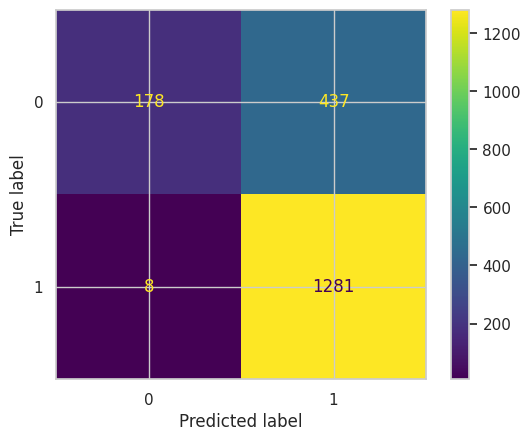

In [311]:
## Confusion matric of tuned Gradient boosting algorithm with feature selection

print("The confusion matrix of tuned Gradient boosting algorithm with feature selection:\n")
ConfusionMatrixDisplay(confusion_matrix(y_gb_test, GBC3_y_pred)).plot()
plt.show()

Hence we can conclude after the feature selection for the important features only on the hyper parameter tuned model.
We have re-built and re-trained the model and got the f2-score from 0.81 in the vanilla model to 0.93 on the feature selected hyper parameter tuned model.



> > **Ensemble Method: Boosting:-- Extreme Gradient boosting classifier (XGBoost)**



In [312]:
# Trying out ensemble boosting method: Extreme Gradient boosting (XGBoost) classifier algorithm

XGB = XGBClassifier(random_state=42)
XGB.fit(x_train, y_train)
XGB_y_pred = XGB.predict(x_test)
XGB_f2_score = fbeta_score(y_test, XGB_y_pred, beta=2)

In [313]:
print("The classification report for Extreme Gradient boosting classifier algorithm before hyperparameter tuning is:\n\n", classification_report(y_test, XGB_y_pred))
print()
print("f-2 beta score for for Extreme Gradient boosting classifier algorithm before hyperparameter tuning is: ",XGB_f2_score)

The classification report for Extreme Gradient boosting classifier algorithm before hyperparameter tuning is:

               precision    recall  f1-score   support

           0       0.79      0.73      0.76      1290
           1       0.75      0.80      0.78      1295

    accuracy                           0.77      2585
   macro avg       0.77      0.77      0.77      2585
weighted avg       0.77      0.77      0.77      2585


f-2 beta score for for Extreme Gradient boosting classifier algorithm before hyperparameter tuning is:  0.7907968916653969


In [314]:
print("The training data accuracy for Extreme Gradient boosting classifier algorithm before hyper paarmeter tuning is:", XGB.score(x_train, y_train))
print("The test data accuracy for Extreme Gradient boosting classifier algorithm before hyper parameter tuning is:", XGB.score(x_test, y_test))

The training data accuracy for Extreme Gradient boosting classifier algorithm before hyper paarmeter tuning is: 1.0
The test data accuracy for Extreme Gradient boosting classifier algorithm before hyper parameter tuning is: 0.7671179883945841


The confusion matrix of Extreme Gradient boosting classifier before hyperparameter tuning:



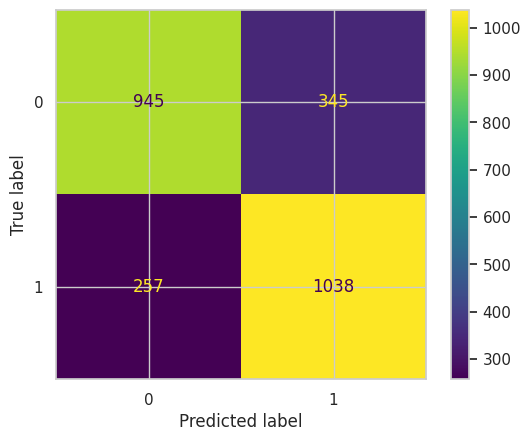

In [315]:
## Confusion matric of Extreme Gradient boosting classifier without any hyperparameters

print("The confusion matrix of Extreme Gradient boosting classifier before hyperparameter tuning:\n")
ConfusionMatrixDisplay(confusion_matrix(y_test, XGB_y_pred)).plot()
plt.show()

In [316]:
## defining parameters for hyper parameter tuning of XGBoost algorithm
XGB_param_grid = {
    'max_depth': [2,3,5,7,9],
    'learning_rate': [0.009,0.01, 0.04, 0.09, 0.1],
    'n_estimators': [50,70,100,200,250,300,450]
}

In [330]:
# # Building a new XGB model to have all defined paarmeters trained and find the best parameters
# f2_scorer = make_scorer(fbeta_score, beta=2)
# XGB_GridSearchCV = GridSearchCV(XGB, param_grid=XGB_param_grid, scoring = f2_scorer, cv=5, n_jobs = -1, verbose = 1)

# XGB_GridSearchCV.fit(x_train, y_train) # training all the parameters defined to the new model


Fitting 5 folds for each of 175 candidates, totalling 875 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.009, 0.01, 0.04, 0.09, 0.1],
                         'max_depth': [2, 3, 5, 7, 9],
                         'n_estimators': [50, 70, 100, 200, 250, 300, 450]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

In [ ]:
# ## fetching the best parameters for XGBoost algorithm: after hyper parameter tuning
# XGB_GridSearchCV.best_params_

In [319]:
#creating a new model and training the model with the best parameters

XGB1 = XGBClassifier(learning_rate=0.01, max_depth=2, n_estimators=111)
XGB1.fit(x_train, y_train)
XGB1_y_pred = XGB1.predict(x_test)
XGB1_f2_score = fbeta_score(y_test, XGB1_y_pred, beta=2)

In [320]:
print("The classification report for Extreme Gradient boosting classifier algorithm after hyperparameter tuning is:\n\n", classification_report(y_test, XGB1_y_pred))
print()
print("f-2 beta score for for Extreme Extreme Gradient boosting classifier algorithm after hyperparameter tuning is: ",XGB1_f2_score)

The classification report for Extreme Gradient boosting classifier algorithm after hyperparameter tuning is:

               precision    recall  f1-score   support

           0       0.86      0.44      0.58      1290
           1       0.63      0.93      0.75      1295

    accuracy                           0.69      2585
   macro avg       0.74      0.69      0.67      2585
weighted avg       0.74      0.69      0.67      2585


f-2 beta score for for Extreme Extreme Gradient boosting classifier algorithm after hyperparameter tuning is:  0.8469445226696705


The confusion matrix of Extreme Gradient boosting classifier after hyperparameter tuning:



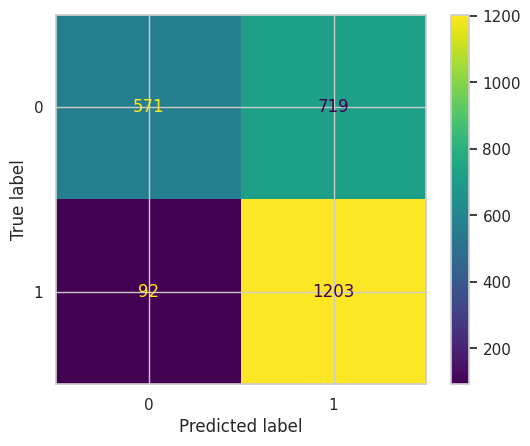

In [321]:
## Confusion matric of Extreme Gradient boosting classifier after hyperparameter tuning

print("The confusion matrix of Extreme Gradient boosting classifier after hyperparameter tuning:\n")
ConfusionMatrixDisplay(confusion_matrix(y_test, XGB1_y_pred)).plot()
plt.show()

We have got an f2-score of 0.8469 after hyper parameter tuning, where we had f2-score of 0.7907 before hyperparameter tuning.

And we can conclude that this is the best model till now where we have got very promising results of lower FP and gretaer TP and TN cases by giving more weightage to FN than FP.

In [322]:
## Checking on the important features / the features which give more weightage on the model training and accuracy score

feature_importance_df_XGB = pd.DataFrame({
    'Feature': x.columns,
    'Importance': XGB1.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df_XGB)

                   Feature  Importance
9    No_of_Months_reported    0.410524
5      Joining Designation    0.203963
1                   Gender    0.150791
10  Total_Revenue_acquired    0.119476
4                   Income    0.115247
0                      Age    0.000000
2                     City    0.000000
3          Education_Level    0.000000
6                    Grade    0.000000
7              Income_flag    0.000000
8              Rating_flag    0.000000


In [323]:
# splitting the data with independent features and dependent feature for building a better model with better accuracy
x_xg = ola_df_model.drop(columns = ['Churn_flag', 'Rating_flag', 'Income_flag', 'Education_Level','City','Age'] , axis=1)
y_xg= ola_df_model['Churn_flag']

In [324]:
# since our dataframe is imbalaced with target variable we will use synthetic oversampling method SMOTE to balance them

print("Before SMOTE")
print(y_xg.value_counts())
print()
smt = SMOTE(random_state=42)

x_smt_xg, y_smt_xg = smt.fit_resample(x_xg, y_xg)
print()
print("After SMOTE")
print(y_smt_xg.value_counts())

Before SMOTE
Churn_flag
1    1616
0     765
Name: count, dtype: int64


After SMOTE
Churn_flag
1    1616
0    1616
Name: count, dtype: int64


In [325]:
## Standard scaling
SS_xg = StandardScaler()
x_xg_scaled = SS_rf.fit_transform(x_xg)

In [326]:
#performing independent and dependent features with train test data split
x_xg_test, x_xg_train, y_xg_test, y_xg_train = train_test_split(x_xg_scaled, y_xg, test_size=0.2, random_state=42)
x_xg_train.shape, x_xg_test.shape, y_xg_train.shape, y_xg_test.shape

((477, 6), (1904, 6), (477,), (1904,))

In [327]:
#creating a new model and training the model with the best parameters

XGB2 = XGBClassifier(learning_rate=0.01, max_depth=2, n_estimators=111)
XGB2.fit(x_xg_train, y_xg_train)
XGB2_y_pred = XGB2.predict(x_xg_test)
XGB2_f2_score = fbeta_score(y_xg_test, XGB2_y_pred, beta=2)

print("The classification report for Extreme Gradient boosting classifier algorithm after feature selection and re-training the model is:\n\n", classification_report(y_xg_test, XGB2_y_pred))
print()
print("f-2 beta score for for Extreme Extreme Gradient boosting classifier algorithm after after feature selection and re-training the model is: ",XGB2_f2_score)

The classification report for Extreme Gradient boosting classifier algorithm after feature selection and re-training the model is:

               precision    recall  f1-score   support

           0       0.96      0.29      0.44       615
           1       0.75      0.99      0.85      1289

    accuracy                           0.77      1904
   macro avg       0.85      0.64      0.65      1904
weighted avg       0.81      0.77      0.72      1904


f-2 beta score for for Extreme Extreme Gradient boosting classifier algorithm after after feature selection and re-training the model is:  0.9317718940936864


The confusion matrix of Random Forest model after hyper parameter tuning:



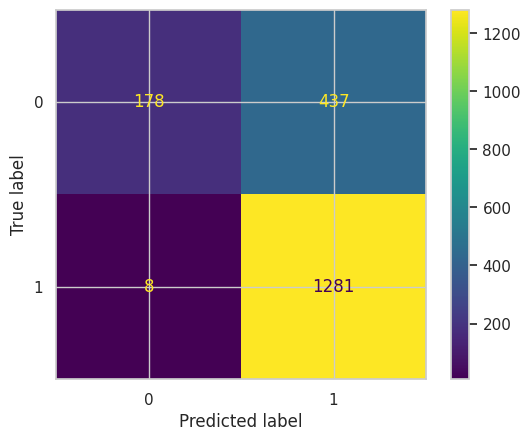

In [328]:
## Confusion matric of  Random Forest without any hyperparameters

print("The confusion matrix of Random Forest model after hyper parameter tuning:\n")
ConfusionMatrixDisplay(confusion_matrix(y_xg_test, XGB2_y_pred)).plot()
plt.show()

Hence we can conclude after the feature selection for the important features only on the hyper parameter tuned model.
We have re-built and re-trained the model and got the f2-score from 0.79 in the vanilla model to 0.93 on the feature selected hyper paarmeter tuned model.

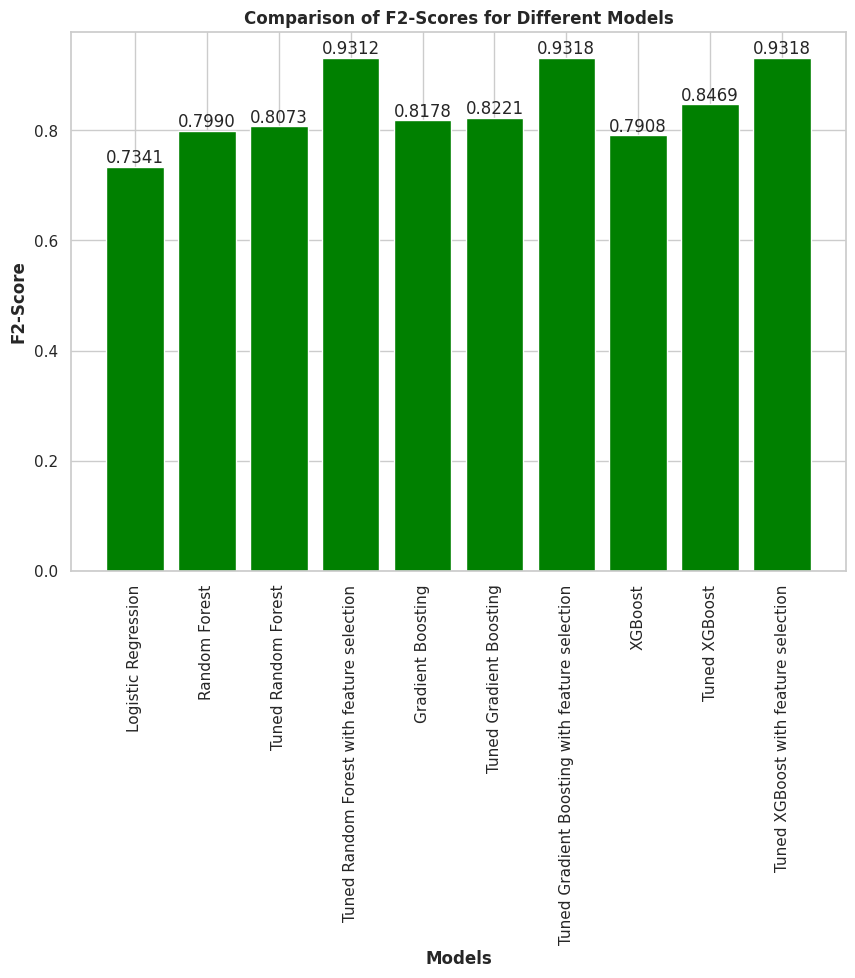

In [329]:
# Creating a bar plot to show the f2-score we have gained from each model trained so far

models = ['Logistic Regression', 'Random Forest', 'Tuned Random Forest','Tuned Random Forest with feature selection',
          'Gradient Boosting', 'Tuned Gradient Boosting', 'Tuned Gradient Boosting with feature selection',
          'XGBoost', 'Tuned XGBoost','Tuned XGBoost with feature selection']
f2_scores = [LR_f2_score,RF_f2_score,RF1_f2_score,RF2_f2_score,GBC_f2_score,GBC2_f2_score,GBC3_f2_score,XGB_f2_score,XGB1_f2_score,XGB2_f2_score]


plt.figure(figsize=(10, 7))
bars = plt.bar(models, f2_scores, color='green')
plt.xlabel('Models', fontweight = 'bold')
plt.ylabel('F2-Score' ,fontweight = 'bold')
plt.title('Comparison of F2-Scores for Different Models', fontweight = 'bold')
plt.xticks(rotation = 90)

for bar, score in zip(bars, f2_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.4f}', ha='center', va='bottom')

plt.show()


🎉 We can observe from the above trend that the models that the Ensemble methods where we have trained by hyper parameter tuning and then by feature selection and to re-build and re-train the model gives very promising results. As we can observe the same behaviour with all 3 ensemble methods tried and they are giivng almost the same results.

# Insights:


**Observations:**
1.   The data we recieved for this casestudy was almost clean with most of the features in numerical hence it did not require much data pre processing steps.
2.   The data recieved was imbacanced in nature, with more drivers with 'LastWorkingDate' and less drivers with NaN on the feature 'LastWorkingDate',so we had to apply SMOTE (Synthetic Over sampling Method) to make the ML results unbiased towards churned drivers.
3. The date features were not in the correct format so had to reformat them for easy calculations and analysis.
5. Navie Baye's algorithm is giving worst results on the given dataframe. Hence we will drop the consideration of algorithm itself.
6. Logistic Regression model is giving average results. So if we ever we need to keep logistic regression as final model then we need to tune the model with regularizer and then perform feature selection using PCA and then again train teh model to increase the score of the results.
7. The ensemble models when hyper parameter tuned are not giving much better results, but the same models when tuned after feature selection are giving much better and promising results.
8. If we need to improve our results more then we can do some feature engineering get consultation with domain experts and see if we want more features to be added in the database and tune the model based on them and see if it will improve its performance.

**Insights:**
1. The data has 60% Male drivers and 40% female drivers.
2. The data had 68% churned drivers and 32% Not churned drivers.
3. The data looks almost balanced with rested to Educational level of the drivers.
4. We have more drivers data with with 'Joinining designation' as 1.
5. We have more drivers data with 'Rating' as 1 and 2, than others.
6. We have more drivers with decreasing income than increasing income.
7. We have more drivers with decreasing quarterly rating than increasing rating.
8. We do not see any cyclical/seasonal pattern for the drivers to churn.
9. The driver count is more in the cities: C20, C15, C29, C26 , C8 an dC27 followed by other cities.
10. The churn rate is higher in every provided raw feature. So we can not randomly guess that this might be the reason for churn by a high level glance.
11. We see that the drivers with age group 30-45 are more in numbers in the entire dataframe.
12. The drivers with age group 30 to 45 tend to increase more revenue for the platform.
13. Features like Education_level, Joining designation and grade at joining are not a significant feature to consider for a driver to think if he/she will churn or not.
14. As churn data is highly co-related to the Number of months a driver reported and the Total revenue a driver acquired for the platform.
15. The more number of months the driver has recorded, the more revenue the driver has generated.
16. The churn rate breaks at a point where the driver tends to generate more than 1cr for the platform.
17. We have also figured out that the churn rate is not dependent on the Negative business impact created by a driver due to EMI/ride cancellation/refunds.



# Recommendation:



1.   The plaform owners have to give some extra perks for drivers with some extra perks if they clear some milestones, so the drivers are attracted to the platform and do not churn easily.
2.   More incentives for drivers with more number of milestones to reduce the churn rate.
3. Train the drivers to give better service to the customers so the driver rating keep increasing which will motivate the driver.
4. Plaform to rate customers along with drivers from teh drivers.
5. Based on the driver's rating the ride allotment has to be tagged to a highly rated customer.
5. With better rating they will get better and more customers then theoir income will increase, which will tend to increase the business and decrease the churn rate.
6. Give some benefits to the drivers like health insurance, road side assistance, vehicle damage cover etc..etc so drivers are happy and they tend to not churn more frequently.
7. Make a new feature in platform to tip the driver by a customer, so the customer is motivated to give a tip and driver is happy with extra incentive.
8. Track the new feature created and see how its helpful in retaining the drivers.
9. Make some restrooms/changing for drivers in the cities where there are more number of drivers, so they are well rested and get freshup while doing daily stressful rides.
10. Have some snacks/meals in the restroom at nominal prices so the drivers are satisfied and happy.

